<a href="https://colab.research.google.com/github/kat-pierzchala/Text_mining-Fairy_Tales/blob/main/Fairy_tales_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from tqdm import tqdm
from nltk import word_tokenize, pos_tag
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.chunk import ne_chunk
from nltk import pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

In [ ]:
%matplotlib inline

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
pip install textblob

In [ ]:
from textblob import TextBlob

In [ ]:
os.getcwd()

'/content'

In [ ]:
filepath = os.path.abspath('/content/fairy_tales.txt')

### Temat
Cel: Analiza sentymentu bajek i identyfikacja dominujących motywów.

- Główne tematy bajek
- Archetypy postaci
- Rozpoznanie nastroju
- Porównanie tematyki
- Czy bajki zawsze mają szczęśliwe zakończenia
- Które archetypy postaci występują najczęściej


###### Techniki:
1. Analiza sentymentu,
2. Word Cloud i analiza częstotliwości słów,
3. Analiza tematyczna,
4. Rozpoznawanie nazw własnych,
5. Analiza narracyjna,
6. Modelowanie tematów,
7. Ewaluacja

### Wczytanie danych i czyszczenie

- Podział na bajki
- Czyszczenie
- Dane treningowe i testowe

### Rozdzielenie tekstu na bajki oraz wyszukanie tytułów

In [ ]:
with open(filepath, 'r', encoding="utf-8") as file:
    text = file.read()

stories = text.split('\n\n')

titles = []
for story in stories:
    lines = list(filter(None, story.strip().split('\n')))
    if not lines:
        continue
    first_line = lines[0].strip()
    match = re.match(r'^[A-Z][A-Za-z\s]{3,50}$', first_line)
    if match:
        titles.append(first_line)

for title in titles[:20]:
    print(title)

Lovely Ilonka
Lucky Luck
The Hairy Man
The Story of the Seven Simons
The Language of Beasts
The Boy Who Could Keep A Secret
The Prince And The Dragon
Little Wildrose
Tiidu The Piper
Paperarelloo
The Gifts Of The Magician
The Strong Prince
The Treasure Seeker
The Cottager And His Cat
The Prince Who Would Seek Immortality
The Three Robes
The Six Hungry Beasts
How The Beggar Boy Turned Into Count Piro
The Rogue And The Herdsman
Eisenkopf


In [ ]:
num_titles = len(titles)
print(f"Liczba bajek: {num_titles}")

Liczba bajek: 587


In [ ]:
stories_data = []

for i, title in enumerate(titles):
    for j, story in enumerate(stories):
        if story.strip().startswith(title):
            content = stories[j].strip()
            if i < len(titles) - 1:
                next_title = titles[i + 1]
                content = "\n".join(
                    [story.strip() for story in stories[j:] if not story.strip().startswith(next_title)]
                )
            stories_data.append({'title': title, 'content': content})
            break

In [ ]:
print(f"Liczba bajek w stories_data: {len(stories_data)}")

Liczba bajek w stories_data: 587


In [ ]:
for story in stories_data[:3]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:300]}...")
    print()

Title: Lovely Ilonka
Content: Lovely Ilonka
There was once a king's son who told his father that he wished to marry.
'No, no!' said the king; 'you must not be in such a hurry. Wait till you
have done some great deed. My father did not let me marry till I had won
the golden sword you see me wear.'
The prince was much disappointed...

Title: Lucky Luck
Content: Lucky Luck
Once upon a time there was a king who had an only son. When the lad was
about eighteen years old his father had to go to fight in a war against
a neighbouring country, and the king led his troops in person. He bade
his son act as Regent in his absence, but ordered him on no account to
mar...

Title: The Hairy Man
Content: The Hairy Man
Somewhere or other, but I don't know where, there lived a king who owned
two remarkably fine fields of rape, but every night two of the rape
heaps were burnt down in one of the fields. The king was extremely angry
at this, and sent out soldiers to catch whoever had set fire to the
rick...

In [ ]:
from sklearn.model_selection import train_test_split

selected_stories = random.sample(stories_data, 200)
print(f"Liczba wybranych bajek: {len(selected_stories)}")

train_data, test_data = train_test_split(selected_stories, test_size=0.2, random_state=42)

print(f"Liczba bajek w zbiorze treningowym: {len(train_data)}")
print(f"Liczba bajek w zbiorze testowym: {len(test_data)}")

Liczba wybranych bajek: 200
Liczba bajek w zbiorze treningowym: 160
Liczba bajek w zbiorze testowym: 40


In [ ]:
print("Przykłady z zestawu treningowego:\n")
for story in train_data[:3]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:300]}...\n")
    print()

print("Przykłady z zestawu testowego:\n")
for story in test_data[:3]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:300]}...")
    print()

Przykłady z zestawu treningowego:

Title: THE FIR TREE
Content: THE FIR TREE
Out in the woods stood a nice little Fir Tree. The place he had was a
very good one: the sun shone on him: as to fresh air, there was enough
of that, and round him grew many large-sized comrades, pines as well as
firs. But the little Fir wanted so very much to be a grown-up tree.
He did...


Title: FAMOUS DONKEY
Content: FAMOUS DONKEY
called
THE STAR OF THE DANCE
     ----
     The Theater will be as Light as Day
That night, as you can well imagine, the theater was filled to
overflowing one hour before the show was scheduled to start.
Not an orchestra chair could be had, not a balcony seat, nor a gallery
seat; not e...


Title: THE LITTLE MATCH GIRL
Content: THE LITTLE MATCH GIRL
Most terribly cold it was; it snowed, and was nearly quite dark, and
evening--the last evening of the year. In this cold and darkness there
went along the street a poor little girl, bareheaded, and with naked
feet. When she left home 

### CZYSZCZENIE DANYCH

##### STOP WORDS

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
num_stop_words = len(stop_words)
print(f"Liczba stop_words: {num_stop_words}")

Liczba stop_words: 179


In [ ]:
stop_word_count = sum([1 for story in selected_stories for word in story['content'].split() if word in stop_words])
print(f'Liczba stop-wordów w zbiorze: {stop_word_count}')

Liczba stop-wordów w zbiorze: 74576463


##### CZYSZCZENIE

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

##### Tworzymy listy:
1. Lista tokenów
2. Lista z przetworzonym tekstem.
3. Lista z przetworzonym tekstem bez usuwania dużych liter - w celu wyczukania imion, nazw własnych.

#### TRENINGOWE

In [ ]:
def clean_text_all(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text.lower())
    tokens_2 = word_tokenize(text)
    tokens_cleaned = [word for word in tokens if word not in stop_words]
    tokens_cleaned_2 = [word for word in tokens_2 if word not in stop_words]
    return (
        tokens_cleaned,
        " ".join(tokens_cleaned) if tokens_cleaned else None,
        " ".join(tokens_cleaned_2) if tokens_cleaned_2 else None
    )

CL_data_tokens = []
CL_data = []
CL_data_names = []

for story in train_data:
    title = story['title']
    content = story['content']
    if len(content.strip()) > 3:
        tokens, cleaned_content, cleaned_content_2 = clean_text_all(content)
        if tokens and cleaned_content and cleaned_content_2:
            CL_data_tokens.append({
                'title': title,
                'tokens': tokens
            })
            CL_data.append({
                'title': title,
                'content': cleaned_content
            })
            CL_data_names.append({
                'title': title,
                'content': cleaned_content_2
            })

#### TESTOWE

In [ ]:
def clean_text_all_test(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text.lower())
    tokens_2 = word_tokenize(text)
    tokens_cleaned = [word for word in tokens if word not in stop_words]
    tokens_cleaned_2 = [word for word in tokens_2 if word not in stop_words]
    return (
        tokens_cleaned,
        " ".join(tokens_cleaned) if tokens_cleaned else None,
        " ".join(tokens_cleaned_2) if tokens_cleaned_2 else None
    )

test_CL_data_tokens = []
test_CL_data = []
test_CL_data_names = []

for story in test_data:
    title = story['title']
    content = story['content']
    if len(content.strip()) > 3:
        tokens, cleaned_content, cleaned_content_2 = clean_text_all_test(content)
        if tokens and cleaned_content and cleaned_content_2:
            test_CL_data_tokens.append({
                'title': title,
                'tokens': tokens
            })
            test_CL_data.append({
                'title': title,
                'content': cleaned_content
            })
            test_CL_data_names.append({
                'title': title,
                'content': cleaned_content_2
            })

#### LEMATYZACJA

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
for item in CL_data_tokens:
    item['tokens'] = [lemmatizer.lemmatize(token) for token in item['tokens']]

In [ ]:
for item in CL_data:
    item['content'] = " ".join([lemmatizer.lemmatize(word) for word in item['content'].split()])

In [ ]:
for item in CL_data_names:
    item['content'] = " ".join([lemmatizer.lemmatize(word) for word in item['content'].split()])

In [ ]:
for item in test_CL_data:
    item['content'] = " ".join([lemmatizer.lemmatize(word) for word in item['content'].split()])

##### Zapis plików do .csv

In [ ]:
CL_data_tokens_df = pd.DataFrame(CL_data_tokens)
CL_data_tokens_df.to_csv('CL_data_tokens_Lem.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_df = pd.DataFrame(CL_data)
CL_data_df.to_csv('CL_data_Lem.csv', index=False, encoding='utf-8')

In [ ]:
CL_data_names_df = pd.DataFrame(CL_data_names)
CL_data_names_df.to_csv('CL_data_names_Lem.csv', index=False, encoding='utf-8')

In [ ]:
test_CL_data_df = pd.DataFrame(test_CL_data)
test_CL_data_df.to_csv('test_CL_data_Lem.csv', index=False, encoding='utf-8')

##### Odczyt plików .csv

In [ ]:
CL_data_df = pd.read_csv('CL_data_Lem.csv', encoding='utf-8')
CL_data = CL_data_df.to_dict(orient='records')

In [ ]:
CL_data_tokens_df = pd.read_csv('CL_data_tokens_Lem.csv', encoding='utf-8')
CL_data_tokens = CL_data_tokens_df.to_dict(orient='records')

In [ ]:
CL_data_names_df = pd.read_csv('CL_data_names_Lem.csv', encoding='utf-8')
CL_data_names = CL_data_names_df.to_dict(orient='records')

In [ ]:
test_CL_data_df = pd.read_csv('test_CL_data_Lem.csv', encoding='utf-8')
test_CL_data = test_CL_data_df.to_dict(orient='records')

###### Przykładowe dane po oczyszczeniu:

In [ ]:
for story in CL_data[:5]:
    print(f"Title: {story['title']}")
    print(f"Content: {story['content'][:200]}...")
    print()

Title: A Lost Paradise
Content: lost paradise middle great forest lived long time ago charcoalburner wife young handsome strong got married thought work would never fail bad times came grew poorer poorer nights went hungry bed becam...

Title: The Cruel Crane Outwitted
Content: cruel crane outwitted long ago bodisat born forest life genius tree standing near certain lotus pond time water used run short dry season certain pond large good many fish crane thought seeing fish mu...

Title: THE GOLDEN GOOSE
Content: golden goose man three sons youngest called dullhead sneered jeered snubbed every possible opportunity one day happened eldest son wished go forest cut wood started mother gave fine rich cake bottle w...

Title: LITTLE SNOW WHITE
Content: little snow white middle winter broad flakes snow falling around certain queen sat working window frame made fine black ebony looking upon snow pricked finger three drops blood fell upon gazed thought...

Title: ELEVENTH EVENING
Content: eleven

### 2. Wstępna eksploracja
- Częstotliwość występowania słów
- Bigramy
- Długości bajek i analiza rozkładu
- Motywy i tematy poruszane w najkrótszych i najdłuższych bajkach
- Aaliza TF-IDF

In [ ]:
all_words = [word for story in CL_data for word in story['content'].split()]
word_counts = Counter(all_words)

In [ ]:
unique_words = set(all_words)
print(f"Liczba unikalnych słów w zbiorze: {len(unique_words)}")

In [ ]:
all_words_tok = [word for story in CL_data_tokens for word in story['content'].split()]
word_counts2 = Counter(all_words_tok)

In [ ]:
unique_words_tok = set(all_words_tok)
print(f"Liczba unikalnych słów w zbiorze: {len(unique_words_tok)}")

Liczba unikalnych słów w zbiorze: 39082


##### 20 najczęściej występujących słów

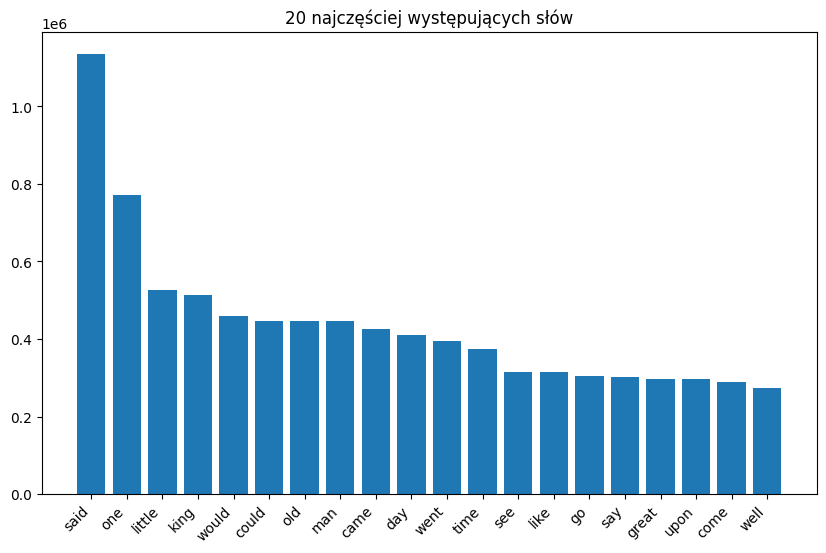

In [ ]:
top_words = word_counts.most_common(20)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 najczęściej występujących słów')
plt.show()

##### Wizualizacja słownictwa charakterystycznego dla bajek - chmura słów

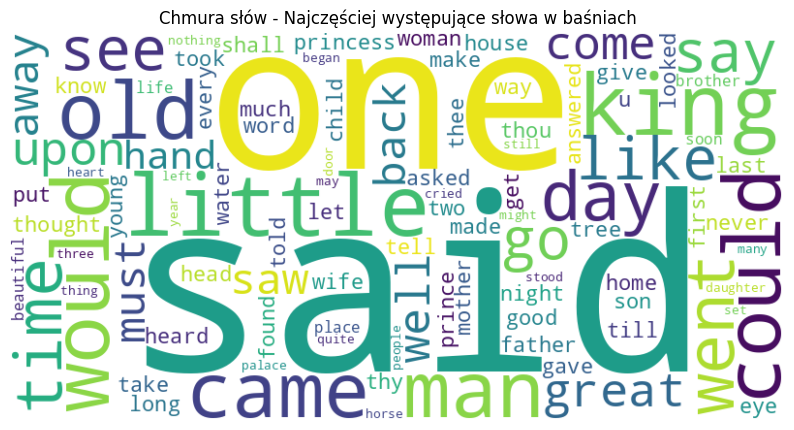

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_counts)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów - Najczęściej występujące słowa w baśniach")
plt.show()

##### Interpretacja
Większość z tych słów wskazuje na klasyczny, narracyjny styl bajek, w którym mamy
- dialogi (said), podróże (went, go, came, away),
- postacie (king, man), w różnym wieku (little, old)
- odniesienia do czasu (day, upon, time).

W bajkach zwykle chodzi o przygody, podróże, moralne nauki, a także o interakcje między różnymi postaciami, co dobrze widać w występujących słowach.

##### BIGRAMY

In [ ]:
def get_ngrams(texts, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(texts)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), ngram_counts))
    return ngram_freq

bigram_freq = get_ngrams([story['content'] for story in CL_data], n=2)

top_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 bigramów:")
for bigram, count in top_bigrams:
    print(f"{bigram}: {count}")

Top 15 bigramów:
old man: 111207
old woman: 83360
young man: 44614
said king: 30804
king son: 30769
said old: 28773
little girl: 26346
thou art: 23485
long time: 23374
thou hast: 23019
said little: 22108
little boy: 20554
went away: 18112
went home: 16324
said princess: 16038


<ipython-input-48-f1b0e1ddf7f7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_labels, palette='viridis')


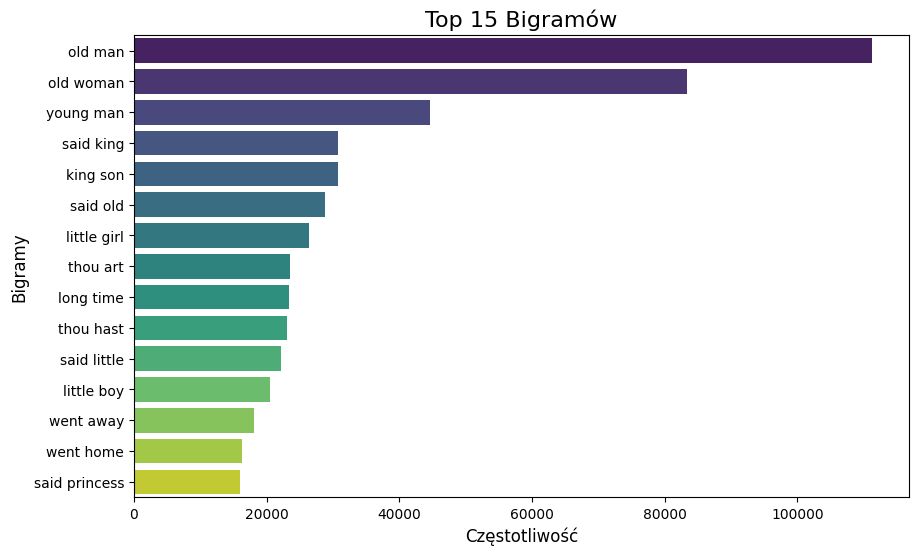

In [ ]:
bigram_labels = [' '.join(bigram.split()) for bigram, _ in top_bigrams]
bigram_counts = [count for _, count in top_bigrams]

plt.figure(figsize=(10, 6))
sns.barplot(x=bigram_counts, y=bigram_labels, palette='viridis')
plt.title("Top 15 Bigramów", fontsize=16)
plt.xlabel("Częstotliwość", fontsize=12)
plt.ylabel("Bigramy", fontsize=12)
plt.show()

#### Interpretacja
##### Postacie:
- Bigramy takie jak „old man”, „old woman”, „young man”, „little girl” i „little boy” wskazują na dominację klasycznych archetypów, które odgrywają centralną rolę w bajkach. Starsze postacie często pełnią role mędrców, mentorów lub antagonistów, podczas gdy młodsze postacie (mężczyźni, dziewczynki, chłopcy) są bohaterami, symbolizującymi niewinność, odwagę i przemiany.

#####  Dialogi i relacje:
- Bigramy takie jak „said old”, „said king”, „said little” wskazują na dużą rolę dialogów, w których starsze postacie lub postacie władzy (król) przekazują mądrości, rozkazy lub wskazówki, które kształtują fabułę. Mówiące dzieci i małe postacie („said little”) mogą symbolizować proste, ale ważne przesłania.

#####  Motywy fabularne:
- Bigramy takie jak „kings son”, „went away”, „went home” sugerują typowe motywy podróży, powrotów do domu, czy dążenia do odzyskania władzy lub sprawiedliwości. W kontekście bajek, które często opowiadają o młodych bohaterach, którzy muszą pokonać trudności lub odbyć podróż, te bigramy odzwierciedlają strukturę fabularną opartą na rozwoju postaci.

##### Język:
- Słowa jak „thou art” i „thou hast” wskazują na archaiczny język, który nadaje bajkom historyczny, magiczny lub fantastyczny ton, który jest charakterystyczny dla tradycyjnych opowieści. Pomaga to w budowaniu atmosfery i przenoszeniu czytelnika w odmienny świat.

##### Długości bajek

In [ ]:
story_lengths = [len(story['content']) for story in CL_data]

In [ ]:
story_word_counts = [len(story['content'].split()) for story in CL_data]

In [ ]:
avg_length = sum(story_word_counts) / len(story_word_counts)
min_length = min(story_word_counts)
max_length = max(story_word_counts)
print(f"Średnia długość bajek (w słowach): {avg_length}")
print(f"Minimalna długość bajek (w słowach): {min_length}")
print(f"Maksymalna długość bajek (w słowach): {max_length}")

Średnia długość bajek (w słowach): 533384.4933333333
Minimalna długość bajek (w słowach): 4835
Maksymalna długość bajek (w słowach): 1075659


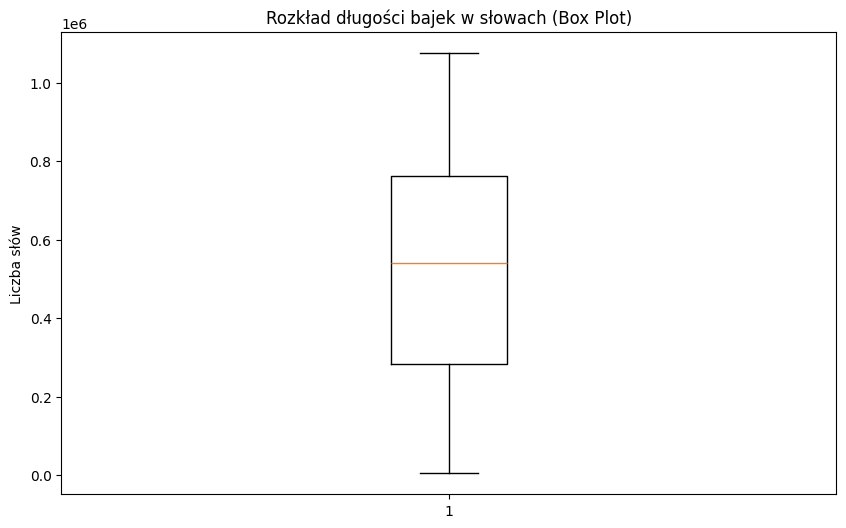

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(story_word_counts)
plt.title('Rozkład długości bajek w słowach (Box Plot)')
plt.ylabel('Liczba słów')
plt.show()

In [ ]:
longest_story = max(CL_data, key=lambda story: len(story['content'].split()))
shortest_story = min(CL_data, key=lambda story: len(story['content'].split()))

In [ ]:
print(f"Najdłuższa bajka: {longest_story['title']} - {len(longest_story['content'].split())} słów")
print(f"Najkrótsza bajka: {shortest_story['title']} - {len(shortest_story['content'].split())} słów")

Najdłuższa bajka: Lucky Luck - 1075659 słów
Najkrótsza bajka: THE TALE OF IVAN - 4835 słów


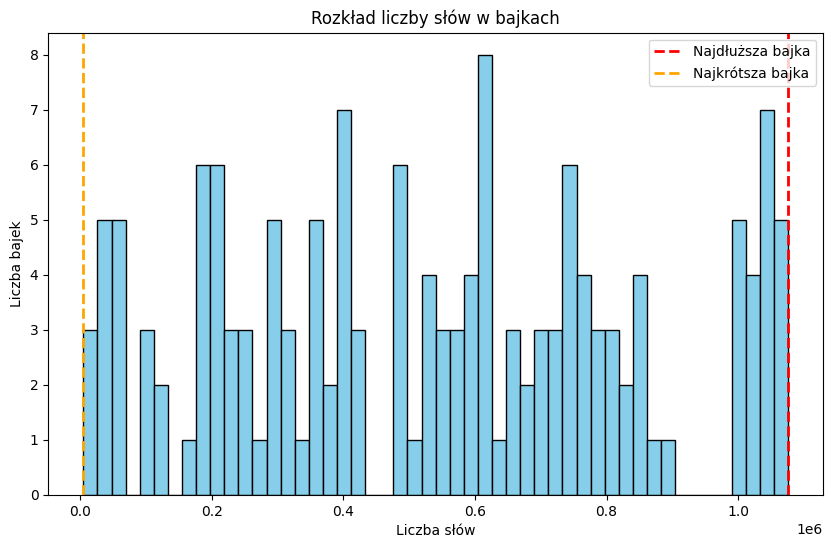

In [ ]:
# Wizualizacja długości bajek z wyróżnieniem najkrótszej i najdłuższej bajki
plt.figure(figsize=(10, 6))
plt.hist(story_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=len(longest_story['content'].split()), color='red', linestyle='dashed', linewidth=2, label='Najdłuższa bajka')
plt.axvline(x=len(shortest_story['content'].split()), color='orange', linestyle='dashed', linewidth=2, label='Najkrótsza bajka')
plt.title('Rozkład liczby słów w bajkach')
plt.xlabel('Liczba słów')
plt.ylabel('Liczba bajek')
plt.legend()
plt.show()

##### Jakie motywy i tematy są poruszane w najkrótszych i najdłuższych bajkach?

In [ ]:
# Obliczanie 10% najkrótszych i najdłuższych bajek
shortest_FT = sorted(CL_data, key=lambda x: len(x['content']))[:int(len(CL_data) * 0.1)]
longest_FT = sorted(CL_data, key=lambda x: len(x['content']), reverse=True)[:int(len(CL_data) * 0.1)]

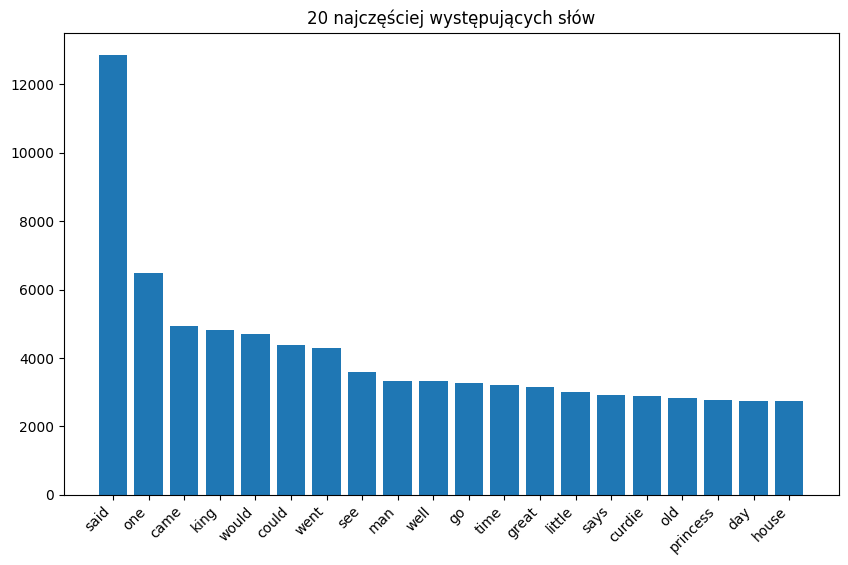

In [ ]:
all_words_s = [word for story in shortest_FT for word in story['content'].split()]
word_counts_s = Counter(all_words_s)
top_words_s = word_counts_s.most_common(20)

words, counts = zip(*top_words_s)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 najczęściej występujących słów')
plt.show()

In [ ]:
bigram_freq_s = get_ngrams([story['content'] for story in shortest_FT], n=2)

top_bigrams_s = sorted(bigram_freq_s.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 bigramów:")
for bigram, count in top_bigrams_s:
    print(f"{bigram}: {count}")

Top 15 bigramów:
old man: 720
kings son: 698
said king: 499
andrew coffey: 479
said curdie: 356
son king: 337
grey beggarman: 308
lank grey: 308
kings daughter: 307
says king: 307
old lady: 300
says giant: 299
dont know: 294
said irene: 287
old woman: 264


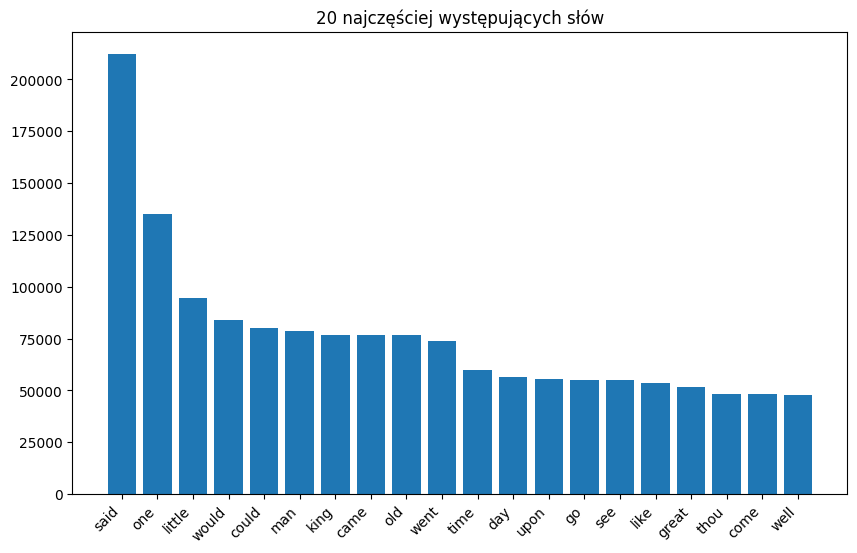

In [ ]:
all_words_b = [word for story in longest_FT for word in story['content'].split()]
word_counts_b = Counter(all_words_b)
top_words_b = word_counts_b.most_common(20)

words, counts = zip(*top_words_b)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 najczęściej występujących słów')
plt.show()

In [ ]:
bigram_freq_b = get_ngrams([story['content'] for story in longest_FT], n=2)

top_bigrams_b = sorted(bigram_freq_b.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 bigramów:")
for bigram, count in top_bigrams_b:
    print(f"{bigram}: {count}")

Top 15 bigramów:
old man: 17072
old woman: 15756
young man: 10448
thou hast: 5610
said old: 4968
said king: 4950
thou art: 4425
kings son: 4386
long time: 4251
little girl: 3933
said little: 3852
thou wilt: 3180
went away: 3124
little boy: 2964
kings daughter: 2849


#### PORÓWNANIE
- Bigramy jak „said king” w bajkach krótkich i długich wskazują, że motywy władzy i roli króla są centralne, ale ich częstotliwość w długich bajkach sugeruje, że są one bardziej rozwinięte w tych opowieściach, a postacie takie jak „kings daughter” i „little girl” dodają różnorodności.
- W najkrótszych bajkach częstymi postaciami są archetypowi bohaterowie, jak „old man” (720) oraz „kings son” (698), które sugerują mądrość oraz dziedziczenie władzy. Postacie te są często bardziej stereotypowe i pełnią klasyczne role.
- W najdłuższych bajkach również pojawiają się „old man” (17,072) i „kings son” (4,386), ale równocześnie mamy większą różnorodność postaci, w tym młodsze postacie jak „young man” (10,448) oraz „little girl” (3,933), co wskazuje na bardziej zróżnicowaną fabułę. Ponadto, pojawiają się formy archaiczne jak „thou hast” (5,610), które podkreślają historyczny lub mitologiczny kontekst.

- Porównanie wniosków z analizy najkrótszych i najdłuższych bajek z interpretacją całego zbioru ujawnia spójność w kwestiach dotyczących archetypów postaci, roli dialogów, motywów fabularnych oraz języka. W krótkich bajkach narracja jest prostsza, z mniejszym naciskiem na rozbudowane dialogi czy archaizmy, podczas gdy w długich bajkach te elementy są bardziej rozwinięte. W obu przypadkach obserwujemy dominację klasycznych postaci, podróży bohaterów i przekazywania mądrości, co odzwierciedla ogólne motywy literackie w bajkach.

### Analiza TF-IDF

Top 20 słów na podstawie TF-IDF:
said        93.800498
little      37.175955
came        35.637847
king        35.338490
old         34.545573
man         34.528542
went        32.909565
time        26.640641
day         25.157257
like        24.999288
great       24.525305
thou        21.609058
come        21.321400
saw         21.002520
away        20.567858
took        19.144189
good        19.068485
long        18.691130
shall       17.443450
princess    17.338158
dtype: float64


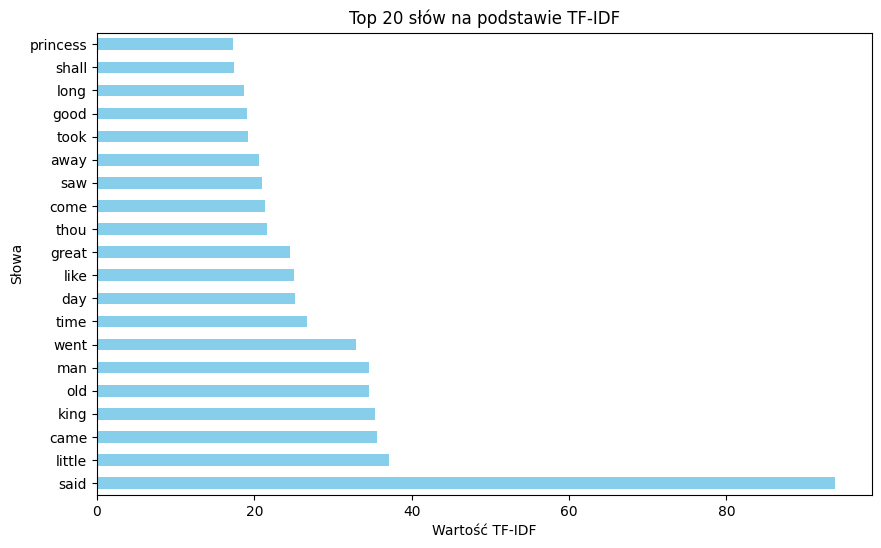

In [ ]:
docs = [' '.join(doc['content'].split()) for doc in CL_data]
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(docs)
tfidf_scores = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

top_tfidf_words = tfidf_scores.sum(axis=0).sort_values(ascending=False).head(20)
print("Top 20 słów na podstawie TF-IDF:")
print(top_tfidf_words)

top_tfidf_words.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 20 słów na podstawie TF-IDF')
plt.xlabel('Wartość TF-IDF')
plt.ylabel('Słowa')
plt.show()

#### Interpretacja:

Wyniki analizy TF-IDF potwierdzają wcześniejsze wyniki. Wskazują, że teksty zawierają wiele słów związanych z klasycznymi motywami bajkowymi, takimi jak postacie królewskie (np. "king", "princess") oraz akcje bohaterów (np. "said", "came", "went"). Często występujące słowa, takie jak "little", "good", "long", podkreślają prostotę języka i emocje w narracji. Elementy narracyjne, takie jak "time", "took", "shall", sugerują, że historie koncentrują się na upływającym czasie i decyzjach bohaterów. Wysokie wartości TF-IDF dla słów takich jak "saw" wskazują na ważność obserwacji i interakcji postaci w fabule.

### 3. Analiza sentymentu:
- Rozkład sentymentu
- Pozytywne/negatywne zakończenia
- Porównanie różnych fragmentów (np. początek, kulminacja, zakończenie).

##### Rozkład sentymentu

In [ ]:
def sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

sentiments = [sentiment(story['content']) for story in CL_data]

polarities = [sentiment[0] for sentiment in sentiments]
subjectivities = [sentiment[1] for sentiment in sentiments]

for story, sentiment_values in zip(CL_data[:5], sentiments[:5]):
    print(f"Story: {story['title']}, Polarity: {sentiment_values[0]}, Subjectivity: {sentiment_values[1]}")

Story: The Prince And The Dragon, Polarity: 0.11308131801459922, Subjectivity: 0.4918933196646665
Story: How The Beggar Boy Turned Into Count Piro, Polarity: 0.11300769113683581, Subjectivity: 0.4920551378112244
Story: How the Little Brother Set Free His Big Brothers, Polarity: 0.11296555784242468, Subjectivity: 0.49217703830372717
Story: Little Lasse, Polarity: 0.11410980224188065, Subjectivity: 0.4953988205620578
Story: FINIS, Polarity: 0.10274865672599874, Subjectivity: 0.4999207043994657


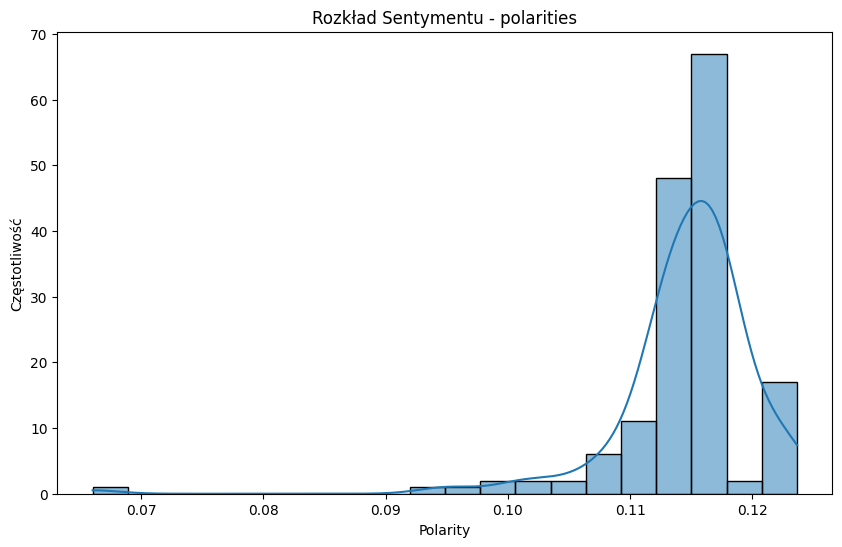

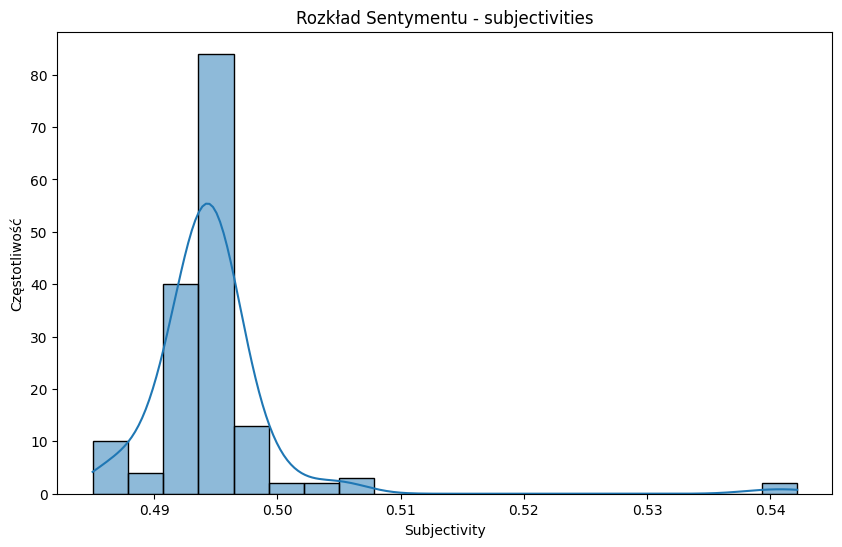

In [ ]:
polarities, subjectivities = zip(*sentiments)

plt.figure(figsize=(10,6))
sns.histplot(polarities, kde=True, bins=20)
plt.title("Rozkład Sentymentu - polarities")
plt.xlabel("Polarity")
plt.ylabel("Częstotliwość")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(subjectivities, kde=True, bins=20)
plt.title("Rozkład Sentymentu - subjectivities")
plt.xlabel("Subjectivity")
plt.ylabel("Częstotliwość")
plt.show()

##### Rozkład kategorii sentymentów

                                               Bajka  Polarity  Subjectivity  \
0  {'title': 'The Prince And The Dragon', 'conten...  0.113081      0.491893   
1  {'title': 'How The Beggar Boy Turned Into Coun...  0.113008      0.492055   
2  {'title': 'How the Little Brother Set Free His...  0.112966      0.492177   
3  {'title': 'Little Lasse', 'content': 'little l...  0.114110      0.495399   
4  {'title': 'FINIS', 'content': 'finis little pr...  0.102749      0.499921   

   Sentyment  
0  Pozytywne  
1  Pozytywne  
2  Pozytywne  
3  Pozytywne  
4  Neutralne  

Liczba dokumentów w każdej kategorii sentymentu:
Sentyment
Pozytywne    142
Neutralne     18
Name: count, dtype: int64


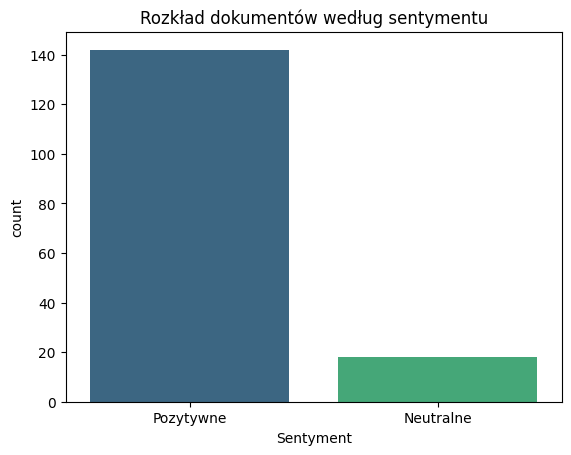

In [ ]:
def sentiment_category(polarity):
    if polarity > 0.11:
        return 'Pozytywne'
    elif polarity < -0.11:
        return 'Negatywne'
    else:
        return 'Neutralne'

sentiments = [sentiment_category(polarity) for polarity in polarities]

CL_data_with_sentiments = pd.DataFrame({
    'Bajka': CL_data[:len(sentiments)],
    'Polarity': polarities,
    'Subjectivity': subjectivities,
    'Sentyment': sentiments
})
print(CL_data_with_sentiments.head())

sentiment_counts = CL_data_with_sentiments['Sentyment'].value_counts()
print("\nLiczba dokumentów w każdej kategorii sentymentu:")
print(sentiment_counts)

sns.countplot(x='Sentyment', data=CL_data_with_sentiments, hue='Sentyment', palette='viridis', legend=False)
plt.title('Rozkład dokumentów według sentymentu')
plt.show()

##### Średnia polarity i subjectivity dla całego zbioru

In [ ]:
average_polarity = sum(polarities) / len(polarities)
average_subjectivity = sum(subjectivities) / len(subjectivities)

print(f"Średnia Polarity: {average_polarity}")
print(f"Średnia Subjectivity: {average_subjectivity}")

Średnia Polarity: 0.11331703877048716
Średnia Subjectivity: 0.49381745628790535


##### Interpretacja wyników:
Polarity - czy tekst jest pozytywny, negatywny, czy neutralny?
- Rozkład oraz średnia polarity wynosząca 0.113, sugerują, że ogólny sentyment tekstów jest raczej neutralny, z tendencją w stronę pozytywnego

Subjectivity:
- Średnia subjectivity na poziomie 0.49 wskazuje, że teksty zawierają równie dużo personalnych opinii (1) co faktycznych informacji(0).

##### Czy bajki są ogólnie pozytywne, neutralne czy negatywne.

In [ ]:
positive_count = sentiments.count('Pozytywne')
neutral_count = sentiments.count('Neutralne')
negative_count = sentiments.count('Negatywne')

total_stories = len(CL_data)
positive_percentage = (positive_count / total_stories) * 100
neutral_percentage = (neutral_count / total_stories) * 100
negative_percentage = (negative_count / total_stories) * 100

In [ ]:
summary_data = {
    'Sentyment': ['Pozytywne', 'Neutralne', 'Negatywne'],
    'Ilość': [positive_count, neutral_count, negative_count],
    'Procent': [positive_percentage, neutral_percentage, negative_percentage]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

   Sentyment  Ilość  Procent
0  Pozytywne    142    88.75
1  Neutralne     18    11.25
2  Negatywne      0     0.00


In [ ]:
sorted_stories = sorted(zip(CL_data, sentiments), key=lambda x: x[1][0], reverse=True)

most_positive = sorted_stories[:5]
most_negative = sorted_stories[-5:]

print("Najbardziej pozytywne bajki:")
for story, sentiment_values in most_positive:
    print(f"Story: {story['title']}")

print("\nNajmniej pozytywne bajki:")
for story, sentiment_values in most_negative:
    print(f"Story: {story['title']}")

Najbardziej pozytywne bajki:
Story: The Prince And The Dragon
Story: How The Beggar Boy Turned Into Count Piro
Story: How the Little Brother Set Free His Big Brothers
Story: Little Lasse
Story: THE STORY OF THE WIND

Najmniej pozytywne bajki:
Story: THE QUEEN OF QUOK
Story: THE KING OF THE POLAR BEARS
Story: CONNLA AND THE FAIRY MAIDEN
Story: He speaks of his wife but euphemistically in the
Story: The Hall of the Goblin Palace


##### Badanie, czy bajki mają pozytywne czy negatywne zakończenia

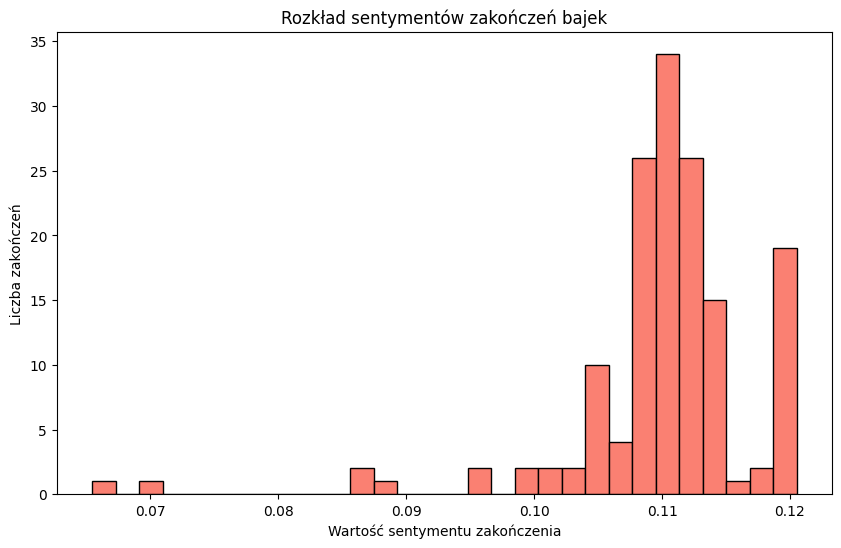

In [ ]:
def split_story(content, part='end'):
    n = len(content)
    if part == 'Początek':
        return content[:int(n * 0.33)]
    elif part == 'Kulminacja':
        return content[int(n * 0.33):int(n * 0.66)]
    elif part == 'Zakończenie':
        return content[int(n * 0.66):]

end_sentiments = []

for story in CL_data:
    ending = split_story(story['content'], 'Zakończenie')
    end_sentiments.append(sentiment(ending)[0])

plt.figure(figsize=(10, 6))
plt.hist(end_sentiments, bins=30, color='salmon', edgecolor='black')
plt.title('Rozkład sentymentów zakończeń bajek')
plt.xlabel('Wartość sentymentu zakończenia')
plt.ylabel('Liczba zakończeń')
plt.show()

##### Porównanie różnych fragmentów (np. początek, kulminacja, zakończenie).

In [ ]:
start_sentiments = []
middle_sentiments = []

for story in CL_data:
    start = split_story(story['content'], 'Początek')
    middle = split_story(story['content'], 'Kulminacja')
    start_sentiments.append(sentiment(start)[0])
    middle_sentiments.append(sentiment(middle)[0])

In [ ]:
start_avg = sum(start_sentiments) / len(start_sentiments)
middle_avg = sum(middle_sentiments) / len(middle_sentiments)
end_avg = sum(end_sentiments) / len(end_sentiments)

print(f"Średnia wartość sentymentu dla początku: {start_avg}")
print(f"Średnia wartość sentymentu dla kulminacji: {middle_avg}")
print(f"Średnia wartość sentymentu dla zakończenia: {end_avg}")

Średnia wartość sentymentu dla początku: 0.11487093468703369
Średnia wartość sentymentu dla kulminacji: 0.11689029785608172
Średnia wartość sentymentu dla zakończenia: 0.11012641971668524


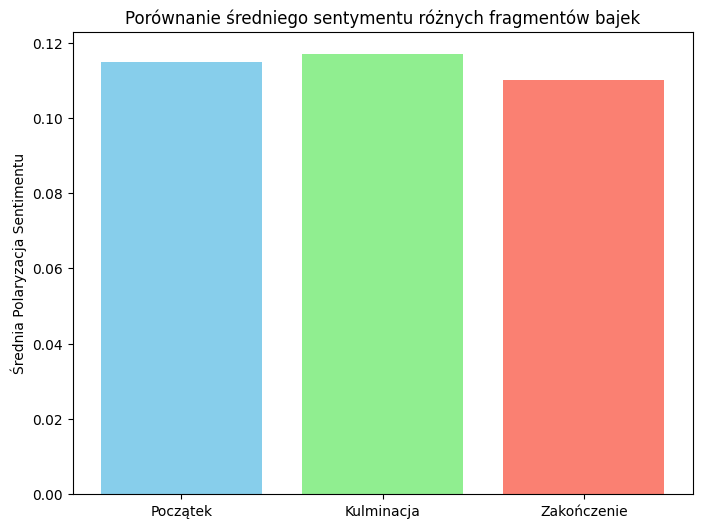

In [ ]:
labels = ['Początek', 'Kulminacja', 'Zakończenie']
avg_sentiments = [start_avg, middle_avg, end_avg]
plt.figure(figsize=(8, 6))
plt.bar(labels, avg_sentiments, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Porównanie średniego sentymentu różnych fragmentów bajek')
plt.ylabel('Średnia Polaryzacja Sentimentu')
plt.show()

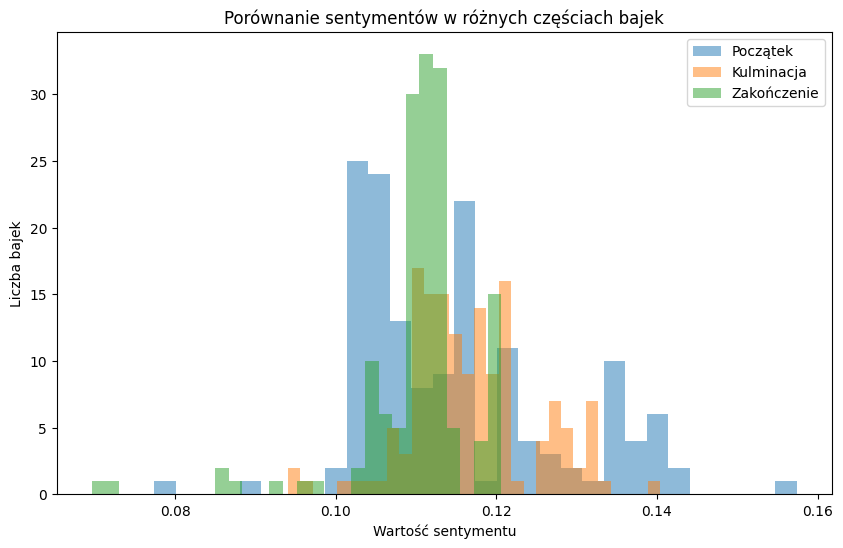

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(start_sentiments, bins=30, alpha=0.5, label='Początek')
plt.hist(middle_sentiments, bins=30, alpha=0.5, label='Kulminacja')
plt.hist(end_sentiments, bins=30, alpha=0.5, label='Zakończenie')
plt.legend()
plt.title('Porównanie sentymentów w różnych częściach bajek')
plt.xlabel('Wartość sentymentu')
plt.ylabel('Liczba bajek')
plt.show()

#### Interpretacja:

Bajki generalnie mają nautralny charakter z lekkim przychłem z stronę pozytywnych. Delikatnie niższą wartość sentymentu mają zakończenia bajek.

In [ ]:
def sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

sentiments = [sentiment(story['content']) for story in test_CL_data]

polarities = [sentiment[0] for sentiment in sentiments]
subjectivities = [sentiment[1] for sentiment in sentiments]

for story, sentiment_values in zip(test_CL_data[:5], sentiments[:5]):
    print(f"Story: {story['title']}, Polarity: {sentiment_values[0]}, Subjectivity: {sentiment_values[1]}")

Story: LITTLE TINY OR THUMBELINA, Polarity: 0.12010659056898774, Subjectivity: 0.4953346826380002
Story: THE NIGHTINGALE, Polarity: 0.11525664763325413, Subjectivity: 0.4935231463279624
Story: The Sacred Milk of Koumongoe, Polarity: 0.11162493267704919, Subjectivity: 0.4920142579228567
Story: DRAKESTAIL, Polarity: 0.11544691064501567, Subjectivity: 0.49338123984384663
Story: How To Find Out A True Friend, Polarity: 0.11144932058274701, Subjectivity: 0.4918221439034013


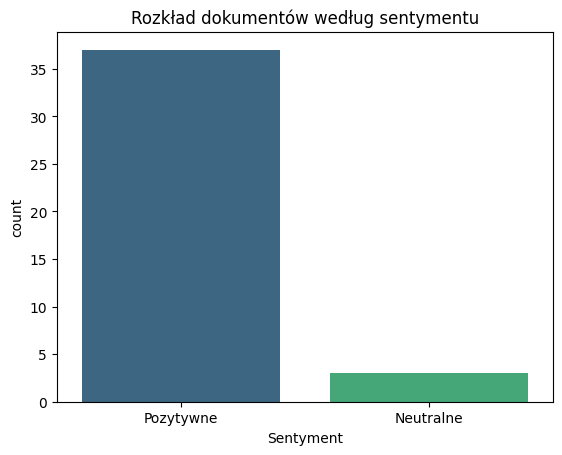

In [ ]:
def sentiment_category(polarity):
    if polarity > 0.11:
        return 'Pozytywne'
    elif polarity < -0.11:
        return 'Negatywne'
    else:
        return 'Neutralne'

sentiments = [sentiment_category(polarity) for polarity in polarities]

test_CL_data_with_sentiments = pd.DataFrame({
    'Bajka': test_CL_data[:len(sentiments)],
    'Polarity': polarities,
    'Subjectivity': subjectivities,
    'Sentyment': sentiments
})

test_sentiment_counts = test_CL_data_with_sentiments['Sentyment'].value_counts()

sns.countplot(x='Sentyment', data= test_CL_data_with_sentiments, hue='Sentyment', palette='viridis', legend=False)
plt.title('Rozkład dokumentów według sentymentu')
plt.show()

### 4. Analiza narracyjna:
- Ekstrakcja imion i nazw własnych
- Rozpoznanie archetypów postaci
- Analiza struktury bajek

In [ ]:
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
import nltk
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


True

##### Ekstrakcja imion i nazw własnych

In [ ]:
def extract_character_names(text):
    names = re.findall(r'\b[A-ZŚŻŹŁĄĆĘÓŃ][a-zśżźłąćęóń]*\b', text)
    return names

In [ ]:
all_names = []

for story in CL_data_names:
    names = extract_character_names(story['content'])
    all_names.extend(names)

unique_names = list(set(all_names))

In [ ]:
unique_names_df = pd.DataFrame(unique_names)
unique_names_df.to_csv('unique_names.csv', index=False, encoding='utf-8')

##### Named Entity Recognition, NER

In [ ]:
!pip install spacy

In [ ]:
!python3 -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_character_names2(text):
    doc = nlp(text)
    names = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            names.append(ent.text)
    return names

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 10_000_000

In [ ]:
all_names_NER = []
for story in CL_data_names:
    content = story['content']
    names = extract_character_names2(content)
    all_names_NER.extend(names)

unique_names_NER = list(set(all_names_NER))

In [ ]:
unique_names_NER_df = pd.DataFrame(unique_names_NER)
unique_names_NER_df.to_csv('unique_names_NER.csv', index=False, encoding='utf-8')

##### Rozpoznanie archetypów postaci: bohater, złoczyńca, pomocnik, księżniczka.

In [ ]:
archetypes = {
    'Bohater': ['knights', 'knight', 'brave', 'good hero', 'hero', 'kings son', 'young man', 'little boy', 'little girl'],
    'Złoczyńca': ['sorcerer', 'villain', 'witch', 'evil', 'enemy', 'devil', 'troll', 'old man', 'old woman', 'giant'],
    'Pomocnik': ['companion', 'guide', 'friend', 'sidekick', 'helper', 'assistant', 'faithful servant', 'old lady', 'said king', 'said curdie', 'said irene'],
    'Księżniczka': ['kings daughter','princess', 'royal princess', 'maiden', 'queen',  'lady', 'damsel'],
    'Mędrzec': ['wizard', 'sage', 'master', 'guide', 'elder', 'mentor','teacher', 'guardian', 'advisor'],
    'Łobuz': ['fool', 'trickster', 'rogue', 'cheater', 'joker'],
    'Niewinny': ['child', 'innocent soul', 'victim', 'simple person'],
    'Władca': ['ruler', 'king', 'prince', 'queen', 'great leader', 'tyrant'],
    'Obrońca': ['knight', 'warrior', 'guard', 'protector'],
    'Towarzysz': ['companion', 'partner', 'sidekick', 'friend'],
    'Rzemieślnik': ['blacksmith', 'craftsman', 'builder', 'merchant', 'artisan', 'worker'],
    'Rodzic': ['father', 'mother', 'parent', 'guardian', 'caretaker', 'protector', 'nurturer'],
    'Dziecko': ['child', 'baby', 'young girl', 'young boy', 'infant', 'kid'],
    'Zwierzęta': ['fox', 'bear', 'wolf', 'bird', 'dog', 'cat', 'rabbit', 'horse', 'lion', 'eagle', 'deer']
}

In [ ]:
def assign_archetype(name):
    for archetype, keywords in archetypes.items():
        for keyword in keywords:
            if keyword in name.lower():
                return archetype
    return 'Nieznany'

In [ ]:
character_archetypes = []
for name in unique_names:
    archetype = assign_archetype(name)
    character_archetypes.append({
        'name': name,
        'archetype': archetype
    })

In [ ]:
data = {
    'Postać': [],
    'Archetyp': []
}
for character in character_archetypes:
    if character['archetype'] != 'Nieznany':
        data['Postać'].append(character['name'])
        data['Archetyp'].append(character['archetype'])

df_archetypes = pd.DataFrame(data)
print(df_archetypes.head(20))

           Postać   Archetyp
0       Babylonis    Dziecko
1   Schoolmasters    Mędrzec
2        Passages    Mędrzec
3       Kingscote    Bohater
4     Rothschilds   Niewinny
5            Kidr    Dziecko
6          Horses  Zwierzęta
7           Giant  Złoczyńca
8            Baby    Dziecko
9         Brogues      Łobuz
10           King    Bohater
11         Knight    Bohater
12        Looking    Bohater
13        Shaking    Bohater
14         Taking    Bohater
15     Catherines  Zwierzęta
16          Devil  Złoczyńca
17    Wonderchild   Niewinny
18   Winedrinking    Bohater
19        Friends   Pomocnik


In [ ]:
df_archetypes_counts = pd.DataFrame(list(archetype_counts.items()), columns=['Archetyp', 'Liczba'])
df_archetypes_counts = df_archetypes_counts.sort_values(by='Liczba', ascending=False)
print(df_archetypes_counts)

       Archetyp  Liczba
13    Zwierzęta      69
0       Bohater      58
1     Złoczyńca      24
4       Mędrzec      20
3   Księżniczka      19
11       Rodzic      16
2      Pomocnik       8
5         Łobuz       8
6      Niewinny       8
12      Dziecko       7
8       Obrońca       5
7        Władca       2
10  Rzemieślnik       2
9     Towarzysz       0


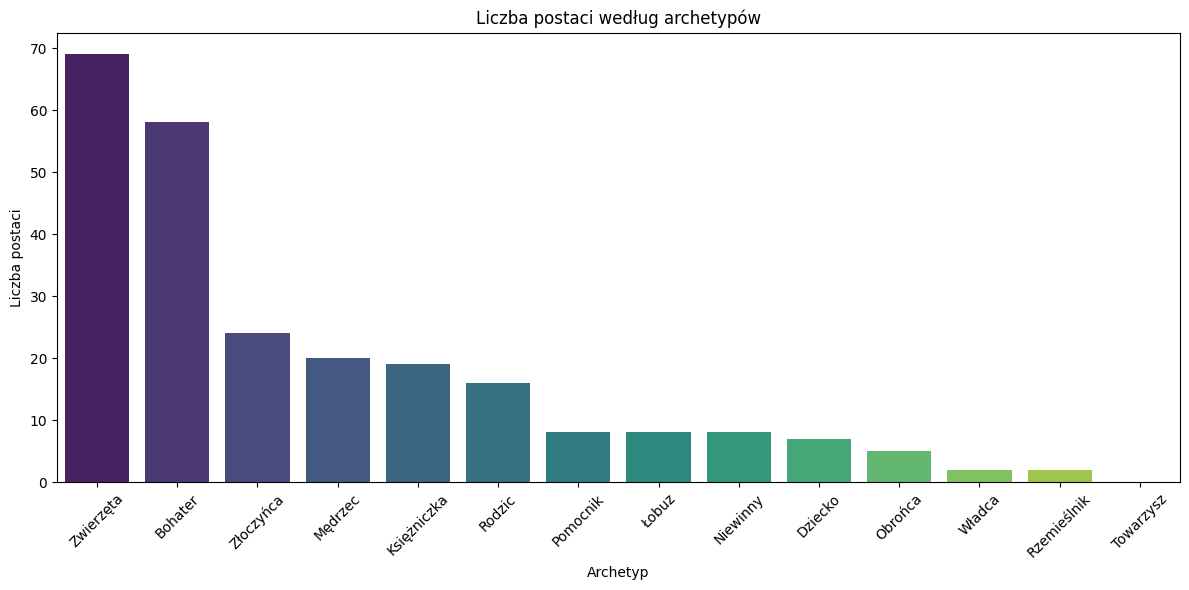

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Archetyp', y='Liczba', hue='Archetyp', data=df_archetypes_counts, palette='viridis', legend=False)
plt.title('Liczba postaci według archetypów')
plt.xlabel('Archetyp')
plt.ylabel('Liczba postaci')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### WNIOSKI

##### Najczęściej występujące archetypy:

- Bohater (58): Jest to najczęstszy archetyp w zbiorze bajek, co sugeruje, że bajki koncentrują się głównie na postaciach, które odgrywają centralną rolę w opowieściach, często jako postaci główne.
- Zwierzęta (69): Również występują bardzo często. Może to wskazywać na dominujący motyw postaci zwierzęcych w bajkach, które pełnią ważną rolę w wielu opowieściach, np. jako towarzysze bohaterów, czy nawet jako personifikowane postacie.


##### Rzadziej występujące archetypy:

- Władca (2): Tylko dwie bajki zawierają postacie w roli władcy. Może to sugerować, że ten archetyp jest mniej obecny w badanych bajkach, a motywy związane z władzą są mniej popularne lub bardziej subtelne.
- Towarzysz (0): Brak postaci typu "towarzysz" może wskazywać, że w analizowanych bajkach rzadziej występują postacie wspierające lub pomocnicze, które nie pełnią głównej roli w historii.
- Rzemieślnik (2): Postać rzemieślnika pojawia się tylko w dwóch bajkach, co może sugerować, że tego typu postacie nie są powszechnie wykorzystywane w tego rodzaju literaturze.

##### Archetypy związane z rolą moralną i społeczną:

- Złoczyńca (24), Mędrzec (20), Łobuz (8): Archetypy złoczyńcy i mędrca są również stosunkowo często spotykane, co może wskazywać na dominację klasycznych motywów walki dobra ze złem i naukowych postaci, które pełnią rolę przewodników lub mentorów.
- Rodzic (16), Dziecko (7), Niewinny (8): Archetypy związane z relacjami rodzinnymi, jak rodzic czy dziecko, są obecne, ale mniej liczne, co może wskazywać, że wiele bajek skupia się bardziej na przygodach niż na głębszych relacjach rodzinnych.

##### Rodzaj bajki:

- Obecność Księżniczki (19) i Zwierząt (69) może sugerować, że analizowane bajki mają częste motywy klasyczne, takie jak królewskie historie, baśnie o księżniczkach, oraz opowieści z silnym wpływem postaci zwierzęcych.

##### Brak równowagi:

- Widać wyraźnie, że wśród archetypów są duże dysproporcje. Niektóre postacie są częściej reprezentowane, co może wskazywać na powtarzalność pewnych motywów w zbiorze bajek.

#### Porównanie między bajkami: jakie archetypy dominują w poszczególnych bajkach.

In [ ]:
unique_names_in_story = set(extract_character_names(story['content']))
print(f"Bajka: {story['title']}, Unikalne postacie: {len(unique_names_in_story)}")

Bajka: STORY THE FIRST, Unikalne postacie: 5410


In [ ]:
def assign_story(story):
    return story['title']

In [ ]:
archetypes_in_stories = []

for story in CL_data_names:
    story_ch = assign_story(story)
    names = extract_character_names(story['content'])
    unique_names = set(names)

    for name in unique_names:
        archetype = assign_archetype(name)
        if archetype != 'Nieznany':
            archetypes_in_stories.append({
                'Nazwa': name,
                'Archetyp': archetype,
                'Bajka': story_ch
            })

In [ ]:
df_archetypes_in_stories = pd.DataFrame(archetypes_in_stories)
archetype_counts = df_archetypes_in_stories.groupby(['Bajka', 'Archetyp']).size().unstack(fill_value=0)
dominujace_archetypy = archetype_counts.idxmax(axis=1)

for bajka, archetyp in dominujace_archetypy.head(10).items():
    liczba = archetype_counts.loc[bajka, archetyp]
    print(f"Bajka: {bajka}, Dominujący archetyp: {archetyp}, Liczba postaci: {liczba}")

Bajka: A Fish Story, Dominujący archetyp: Zwierzęta, Liczba postaci: 63
Bajka: A LEGEND OF KNOCKMANY, Dominujący archetyp: Władca, Liczba postaci: 4
Bajka: ANDREW COFFEY, Dominujący archetyp: Władca, Liczba postaci: 1
Bajka: Adventures of Gilla na Chreck an Gour, Dominujący archetyp: Zwierzęta, Liczba postaci: 27
Bajka: Andras Baive, Dominujący archetyp: Zwierzęta, Liczba postaci: 28
Bajka: BUSHY BRIDE, Dominujący archetyp: Zwierzęta, Liczba postaci: 58
Bajka: Blue Beard, Dominujący archetyp: Zwierzęta, Liczba postaci: 37
Bajka: CONNLA AND THE FAIRY MAIDEN, Dominujący archetyp: Władca, Liczba postaci: 5
Bajka: DAPPLEGRIM, Dominujący archetyp: Zwierzęta, Liczba postaci: 61
Bajka: DRAKESTAIL, Dominujący archetyp: Zwierzęta, Liczba postaci: 61


In [ ]:
for bajka, counts in archetype_counts.head(10).iterrows():
    sorted_counts = counts.sort_values(ascending=False).head(3)
    archetypes = sorted_counts.index.tolist()
    liczby = sorted_counts.values.tolist()
    print(f"Bajka: {bajka}, Dominujący archetyp: {archetypes[0]}, Drugi archetyp: {archetypes[1]}, Trzeci archetyp: {archetypes[2]}, Liczba postaci: {liczby[0] + liczby[1] + liczby[2]}")

Bajka: A Fish Story, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 126
Bajka: A LEGEND OF KNOCKMANY, Dominujący archetyp: Władca, Drugi archetyp: Mędrzec, Trzeci archetyp: Rodzic, Liczba postaci: 6
Bajka: ANDREW COFFEY, Dominujący archetyp: Władca, Drugi archetyp: Złoczyńca, Trzeci archetyp: Bohater, Liczba postaci: 2
Bajka: Adventures of Gilla na Chreck an Gour, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 59
Bajka: Andras Baive, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 60
Bajka: BUSHY BRIDE, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 115
Bajka: Blue Beard, Dominujący archetyp: Zwierzęta, Drugi archetyp: Władca, Trzeci archetyp: Księżniczka, Liczba postaci: 72
Bajka: CONNLA AND THE FAIRY MAIDEN, Dominujący archetyp: Władca, Drugi archetyp: Zwierzęta, Trzec

In [ ]:
results = []

for bajka, counts in archetype_counts.head(10).iterrows():
    sorted_counts = counts.sort_values(ascending=False).head(3)
    archetypes = sorted_counts.index.tolist()
    liczby = sorted_counts.values.tolist()
    results.append({
        'Bajka': bajka,
        'Dominujący archetyp': archetypes[0],
        'Drugi archetyp': archetypes[1],
        'Trzeci archetyp': archetypes[2],
        'Liczba postaci': liczby[0] + liczby[1] + liczby[2]
    })

df_results = pd.DataFrame(results)
print(df_results)

                                   Bajka Dominujący archetyp Drugi archetyp  \
0                           A Fish Story           Zwierzęta         Władca   
1                  A LEGEND OF KNOCKMANY              Władca        Mędrzec   
2                          ANDREW COFFEY              Władca      Złoczyńca   
3  Adventures of Gilla na Chreck an Gour           Zwierzęta         Władca   
4                           Andras Baive           Zwierzęta         Władca   
5                            BUSHY BRIDE           Zwierzęta         Władca   
6                             Blue Beard           Zwierzęta         Władca   
7            CONNLA AND THE FAIRY MAIDEN              Władca      Zwierzęta   
8                             DAPPLEGRIM           Zwierzęta         Władca   
9                             DRAKESTAIL           Zwierzęta         Władca   

  Trzeci archetyp  Liczba postaci  
0     Księżniczka             126  
1          Rodzic               6  
2         Bohater     

In [ ]:
archetype_counts_overall = pd.concat([archetype_counts[col] for col in archetype_counts.columns], axis=0)
archetype_counts_overall = archetype_counts_overall.groupby(archetype_counts_overall.index).sum().sort_values(ascending=False)
print(archetype_counts_overall.head(10))

In [ ]:
bajka_to_plot = df_results.iloc[0]
archetypes_to_plot = bajka_to_plot[['Dominujący archetyp', 'Drugi archetyp', 'Trzeci archetyp']]
liczby_to_plot = bajka_to_plot[['Liczba postaci']].values

plt.figure(figsize=(8, 6))
plt.bar(archetypes_to_plot, liczby_to_plot.flatten())
plt.title(f'Archetypy w bajce: {bajka_to_plot["Bajka"]}')
plt.xlabel('Archetyp')
plt.ylabel('Liczba postaci')
plt.show()

##### Analiza relacji między postaciami, jak często pojawiają się razem i jakie są ich relacje.

In [ ]:
from collections import defaultdict

co_occurrence2 = defaultdict(lambda: defaultdict(int))

for story in CL_data_names:
    names = list(set(extract_character_names(story['content'])))

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            name1, name2 = names[i], names[j]
            co_occurrence2[name1][name2] += 1
            co_occurrence2[name2][name1] += 1

co_occurrence_df2 = pd.DataFrame(co_occurrence2)
print(co_occurrence_df2.head(10))

              Bragshaws  Crunch  Porters  Mostly  Haotsai  Wherever  Judeus  \
Crunch             26.0     NaN     28.0    28.0     28.0      28.0    28.0   
Porters            26.0    28.0      NaN    28.0     28.0      28.0    28.0   
Mostly             26.0    28.0     28.0     NaN     29.0      29.0    28.0   
Haotsai            26.0    28.0     28.0    29.0      NaN      29.0    28.0   
Wherever           26.0    28.0     28.0    29.0     29.0       NaN    28.0   
Judeus             26.0    28.0     28.0    28.0     28.0      28.0     NaN   
Herself            26.0    28.0     28.0    29.0     29.0      29.0    28.0   
Dinar              26.0    27.0     27.0    27.0     27.0      27.0    27.0   
Nashshar           26.0    27.0     27.0    27.0     27.0      27.0    27.0   
Twentyeighth       26.0    27.0     27.0    27.0     27.0      27.0    27.0   

              Herself  Dinar  Nashshar  ...  Gunnfjoder  Comber  Agrippinas  \
Crunch           28.0   27.0      27.0  ...        

In [ ]:
co_occurrence_df2 = pd.DataFrame(co_occurrence).fillna(0)

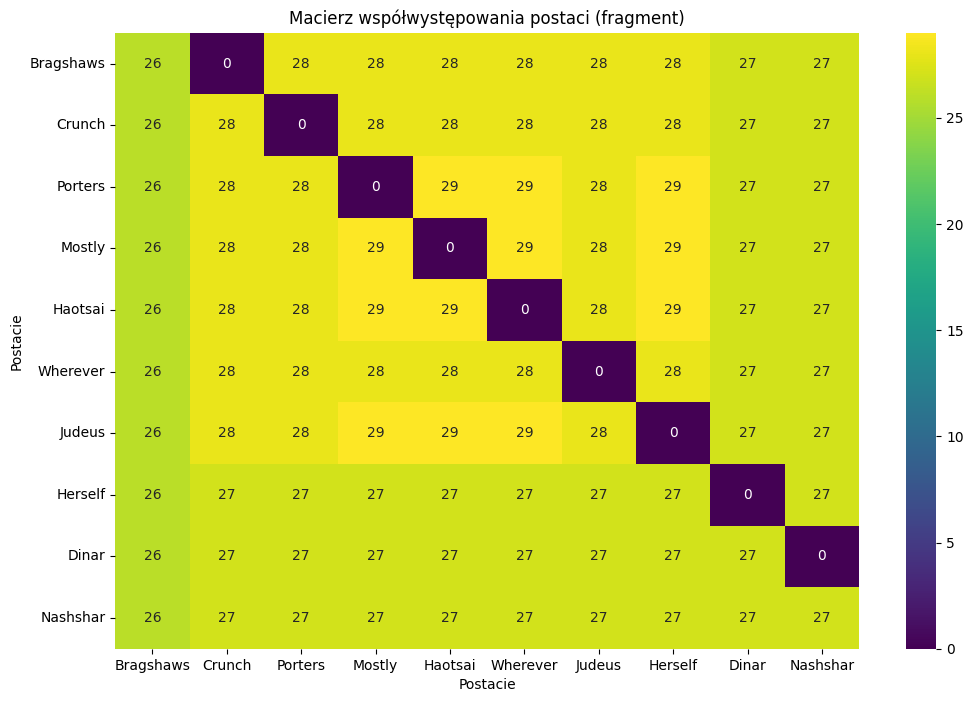

In [ ]:
subset_df = co_occurrence_df2.iloc[:10, :10]
subset_df.index = subset_df.columns

plt.figure(figsize=(12, 8))
sns.heatmap(subset_df, annot=True, fmt="g", cmap="viridis")
plt.title("Macierz współwystępowania postaci (fragment)")
plt.xlabel("Postacie")
plt.ylabel("Postacie")
plt.show()

In [ ]:
co_occurrence_sum = co_occurrence_df2.sum(axis=1)
top_characters = co_occurrence_sum.sort_values(ascending=False).head(10)

top_characters_names = top_characters.index.tolist()
print(top_characters_names)

[2859, 1551, 1172, 900, 3441, 895, 891, 2906, 2182, 423]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

for topic_idx, topic in enumerate(lda.components_):
    print(f"Temat #{topic_idx}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11 - 1:-1]])

### 5. Grupowanie i Analiza tematyczna (Topic Modeling):
- Wydobycie głównych motywów w bajkach

##### TOPIC MODELING

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=4, stop_words='english')
dtm = vectorizer.fit_transform([story['content'] for story in CL_data])

lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Temat {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-no_top_words:][::-1]]))

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)

Temat 1:
sultan emperor allah dragon slave troll book gerda han hut
Temat 2:
allah arab monkey wazir slave book aldin dragon caliph finn
Temat 3:
allah sultan slave rudy arab caliph gerda hut book tzar
Temat 4:
sultan allah slave emperor hut caliph arab book dragon gerda
Temat 5:
note slave allah sultan arab pinocchio hut emperor wezeer book
Temat 6:
argue distasteful traditional gunpowder absurdity famously hitting footmark ruffian trample
Temat 7:
pinocchio marionette sultan slave allah emperor book hut dragon troll


In [ ]:
CL_data_texts = [doc['content'] for doc in CL_data]

vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=4,
    stop_words='english',
    max_features=5000
)
doc_term_matrix = vectorizer.fit_transform(CL_data_texts)

print(f"Kształt macierzy dokument-term: {doc_term_matrix.shape}")

Kształt macierzy dokument-term: (160, 5000)


In [ ]:
lda_model = LatentDirichletAllocation(
    n_components=7,
    random_state=42,
    learning_method='batch'
)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=7, random_state=42)

In [ ]:
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"Temat {idx + 1}: {', '.join(top_features)}")
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda_model, feature_names)
for topic in topics:
    print(topic)

Temat 1: wazir, monkey, aldin, book, finn, dragon, caliph, ifrit, ian, hasan
Temat 2: note, hut, pinocchio, wezeer, shop, dragon, book, emperor, monkey, gerda
Temat 3: note, emperor, pinocchio, wezeer, book, monkey, khaleefeh, hut, verse, dragon
Temat 4: caliph, book, gerda, rudy, hut, monkey, frog, poet, tzar, wazir
Temat 5: emperor, caliph, hut, book, frog, gerda, dragon, monkey, han, rudy
Temat 6: emperor, dragon, book, hut, gerda, pinocchio, han, troll, caliph, monkey
Temat 7: monkey, dragon, butterfly, book, urashima, momotaro, crab, mandarin, jim, sparrow


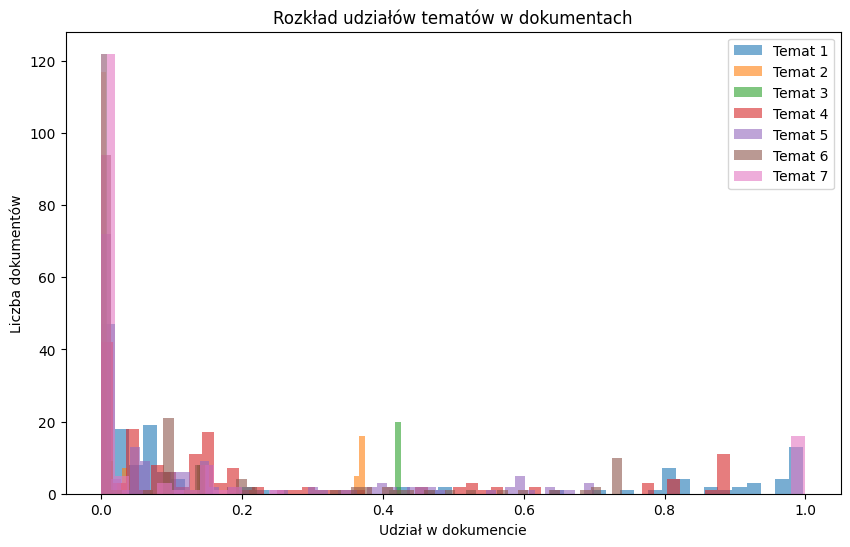

In [ ]:
doc_topic_distribution = lda_model.transform(doc_term_matrix)

plt.figure(figsize=(10, 6))
for topic_idx in range(lda_model.n_components):
    plt.hist(doc_topic_distribution[:, topic_idx], bins=50, alpha=0.6, label=f'Temat {topic_idx + 1}')
plt.xlabel('Udział w dokumencie')
plt.ylabel('Liczba dokumentów')
plt.title('Rozkład udziałów tematów w dokumentach')
plt.legend()
plt.show()

#### Tematy na podstawie słów kluczowych:


Temat 1: **Baśnie o władcach i fantastycznych stworzeniach**
Słowa sugerują historie z baśni, w których pojawiają się władcy, mityczne stworzenia oraz skromne, wiejskie elementy (np. chatki).

Temat 2: **Baśnie arabskie z magicznymi i królewskimi motywami**
Wyrazy wskazują na motywy znane z arabskich baśni, takich jak opowieści o kalifach, małpach jako symbolach magii czy bohaterach pokroju Aladyna.

Temat 3: **Władza, magia i orientalne wątki**
Słowa mogą reprezentować historie z orientalnymi wątkami, w których władcy i magia odgrywają główną rolę.

Temat 4: **Królewskie opowieści i baśnie o władzy**
Wyrazy wskazują na tematy związane z władzą, magią oraz różnorodnymi światami baśniowymi.

Temat 5: **Połączenie motywów królewskich i moralnych**
Historie, które łączą moralne przesłania (np. z postacią Pinokia) z królewskimi wątkami.

Temat 6: **Humor, ironia i absurdy**
Słowa sugerują tematykę bardziej humorystyczną lub ironiczną, gdzie historie mogą mieć elementy satyryczne.

Temat 7: **Baśnie o marionetkach, władcach i stworzeniach fantastycznych**
Słowa wskazują na historie, które łączą motywy marionetek, królewskich postaci i baśniowych stworzeń.

##### Średni udział tematów w dokumentach

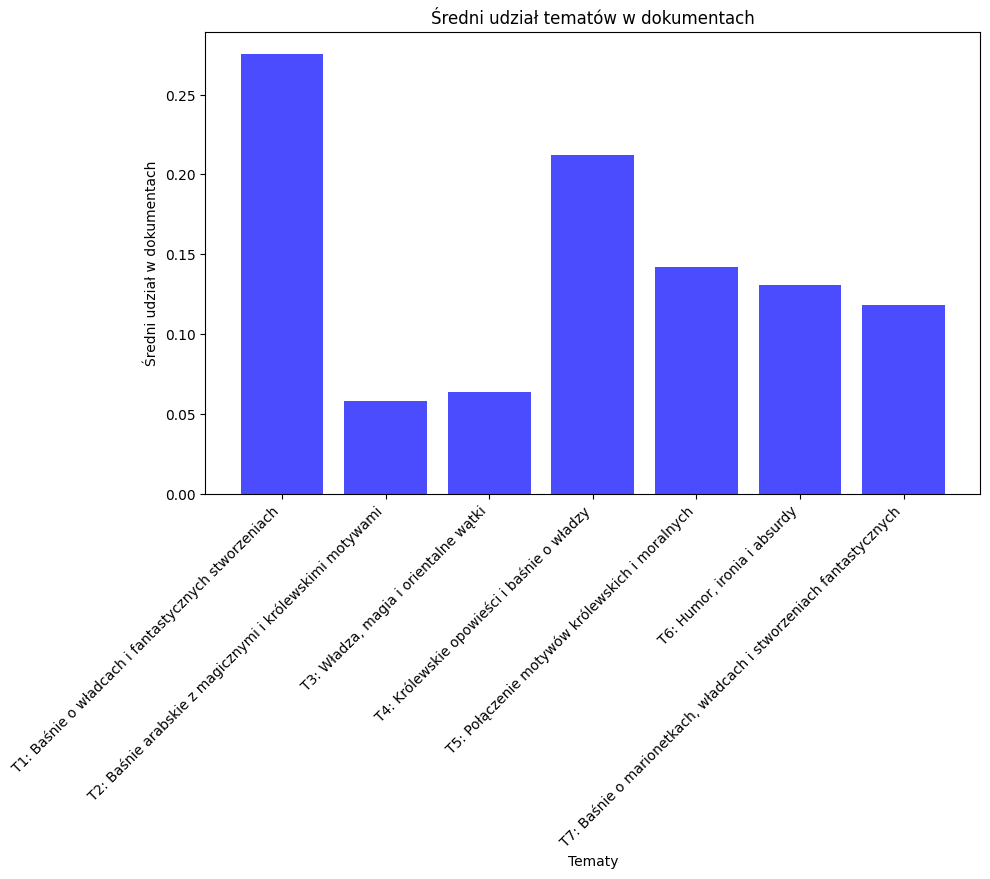

In [ ]:
doc_topic_distribution = lda_model.transform(doc_term_matrix)
plt.figure(figsize=(10, 6))
topic_contribution = np.mean(doc_topic_distribution, axis=0)

topic_names = [
    'T1: Baśnie o władcach i fantastycznych stworzeniach',
    'T2: Baśnie arabskie z magicznymi i królewskimi motywami',
    'T3: Władza, magia i orientalne wątki',
    'T4: Królewskie opowieści i baśnie o władzy',
    'T5: Połączenie motywów królewskich i moralnych',
    'T6: Humor, ironia i absurdy',
    'T7: Baśnie o marionetkach, władcach i stworzeniach fantastycznych'
]

plt.bar(range(lda_model.n_components), topic_contribution, alpha=0.7, color='b', tick_label=topic_names)
plt.xlabel('Tematy')
plt.ylabel('Średni udział w dokumentach')
plt.title('Średni udział tematów w dokumentach')
plt.xticks(rotation=45, ha='right')
plt.show()

##### Dominujące tematy w dokumentach

In [ ]:
CL_data_titles = [story['title'] for story in CL_data]
topic_assignments = doc_topic_distribution.argmax(axis=1)

CL_data_topics = pd.DataFrame({
    'Dokument': CL_data_titles,
    'Dominujący temat': [topic_names[i] for i in topic_assignments]
})

print(CL_data_topics.head(10))

                                           Dokument  \
0                         The Prince And The Dragon   
1         How The Beggar Boy Turned Into Count Piro   
2  How the Little Brother Set Free His Big Brothers   
3                                      Little Lasse   
4                                             FINIS   
5                             THE STORY OF THE WIND   
6                         THE LAUGHING HIPPOPOTAMUS   
7                                  THE FALSE COLLAR   
8                                  THE TALE OF IVAN   
9                             THE STORY OF A MOTHER   

                                    Dominujący temat  
0               T3: Władza, magia i orientalne wątki  
1               T3: Władza, magia i orientalne wątki  
2               T3: Władza, magia i orientalne wątki  
3                        T6: Humor, ironia i absurdy  
4  T7: Baśnie o marionetkach, władcach i stworzen...  
5  T1: Baśnie o władcach i fantastycznych stworze...  
6  T7: Ba

##### Rozkład sentymentów w różnych tematach

In [ ]:
CL_data_with_sentiments_df = pd.DataFrame(CL_data_with_sentiments)

In [ ]:
CL_data_with_sentiments_df['Dominujący temat'] = [topic_names[i] for i in topic_assignments]

In [ ]:
print(CL_data_with_sentiments_df.columns)

Index(['Bajka', 'Polarity', 'Subjectivity', 'Sentyment', 'Dominujący temat',
       'Length'],
      dtype='object')


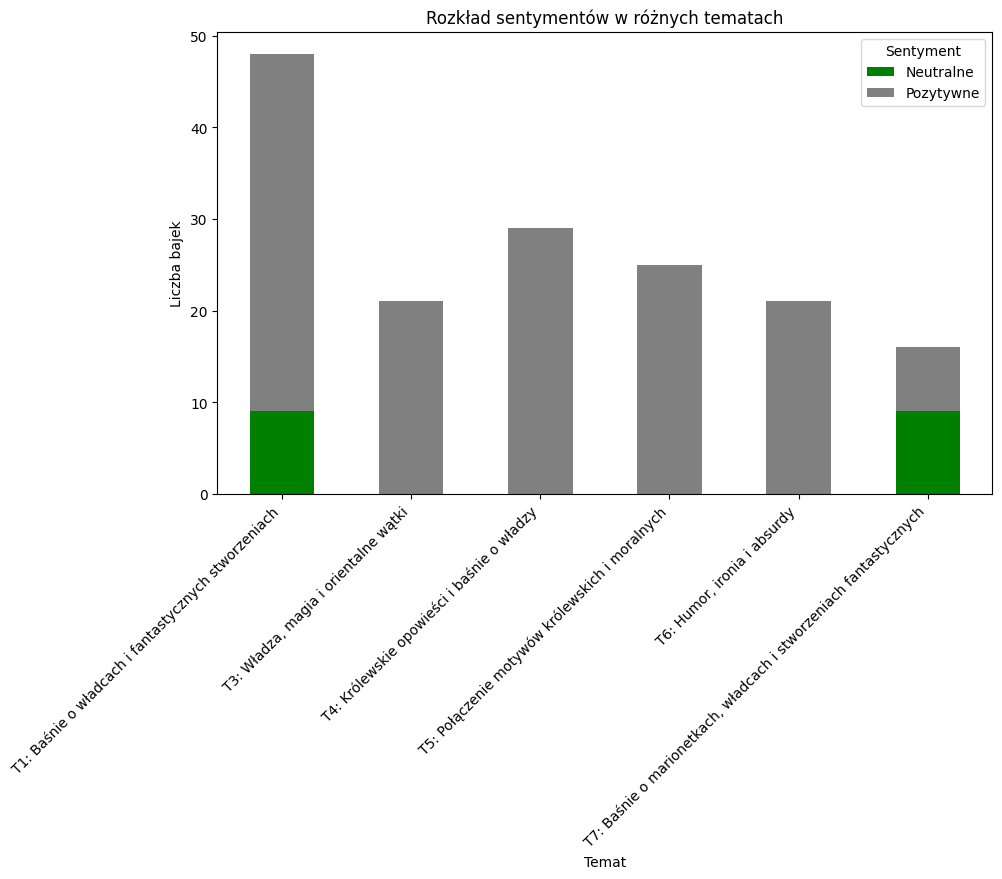

In [ ]:
sentiment_per_topic = CL_data_with_sentiments_df.groupby(['Dominujący temat', 'Sentyment']).size().unstack().fillna(0)
sentiment_per_topic.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'gray', 'red'])
plt.title('Rozkład sentymentów w różnych tematach')
plt.xlabel('Temat')
plt.ylabel('Liczba bajek')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
CL_data_texts_df = pd.DataFrame(CL_data_texts, columns=["content"])
CL_data_texts_df.to_csv('CL_data_text.csv', index=False)
CL_data_topics_df = pd.DataFrame(CL_data_topics, columns=["content"])
CL_data_topics_df.to_csv('CL_data_topics.csv', index=False)

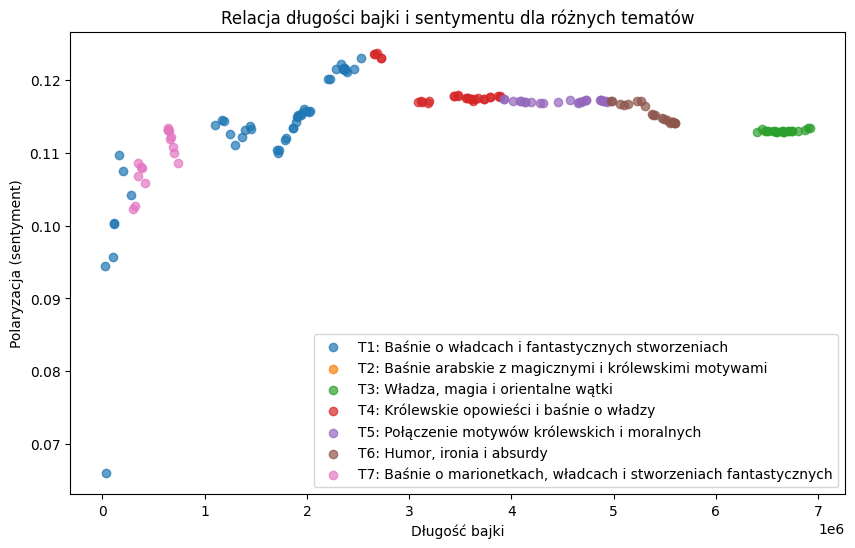

In [ ]:
CL_data_with_sentiments_df['Length'] = CL_data_with_sentiments_df['Bajka'].apply(len)

plt.figure(figsize=(10, 6))
for topic in topic_names:
    topic_data = CL_data_with_sentiments_df[CL_data_with_sentiments_df['Dominujący temat'] == topic]
    plt.scatter(topic_data['Length'], topic_data['Polarity'], label=topic, alpha=0.7)

plt.xlabel('Długość bajki')
plt.ylabel('Polaryzacja (sentyment)')
plt.title('Relacja długości bajki i sentymentu dla różnych tematów')
plt.legend()
plt.show()

In [ ]:
doc_topic_df = pd.DataFrame(doc_topic_distribution, columns=[f'Temat {i+1}' for i in range(lda_model.n_components)])
doc_topic_df['Sentyment'] = CL_data_with_sentiments_df['Sentyment']

sentiment_topic_avg = doc_topic_df.groupby('Sentyment').mean()
print(sentiment_topic_avg)

            Temat 1   Temat 2   Temat 3   Temat 4   Temat 5   Temat 6  \
Sentyment                                                               
Neutralne  0.117652  0.063634  0.063634  0.063634  0.063634  0.063634   
Pozytywne  0.295471  0.057514  0.063525  0.230760  0.151758  0.139527   

            Temat 7  
Sentyment            
Neutralne  0.564180  
Pozytywne  0.061445  


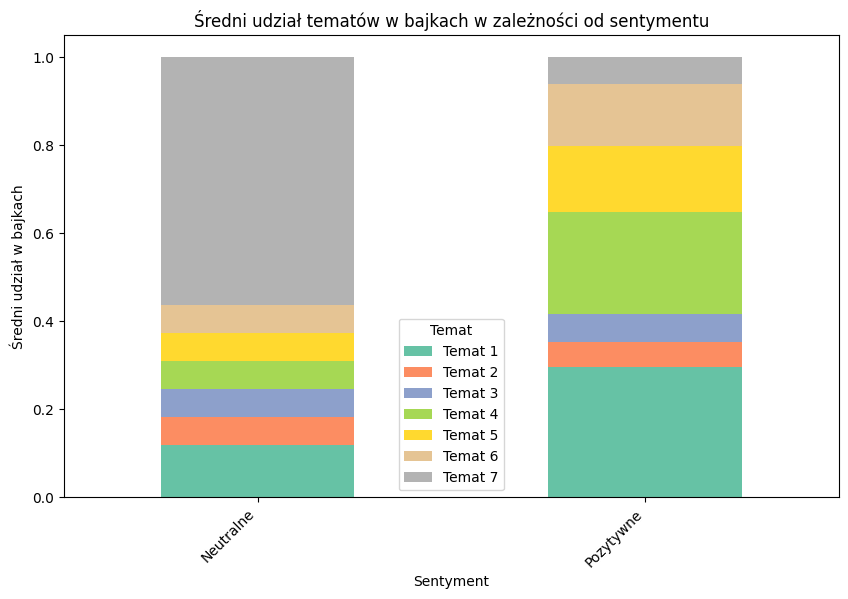

In [ ]:
sentiment_topic_avg.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

plt.title('Średni udział tematów w bajkach w zależności od sentymentu')
plt.xlabel('Sentyment')
plt.ylabel('Średni udział w bajkach')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Temat', labels=[f'Temat {i+1}' for i in range(lda_model.n_components)])
plt.show()

##### Średni sentyment w zależności od tematu

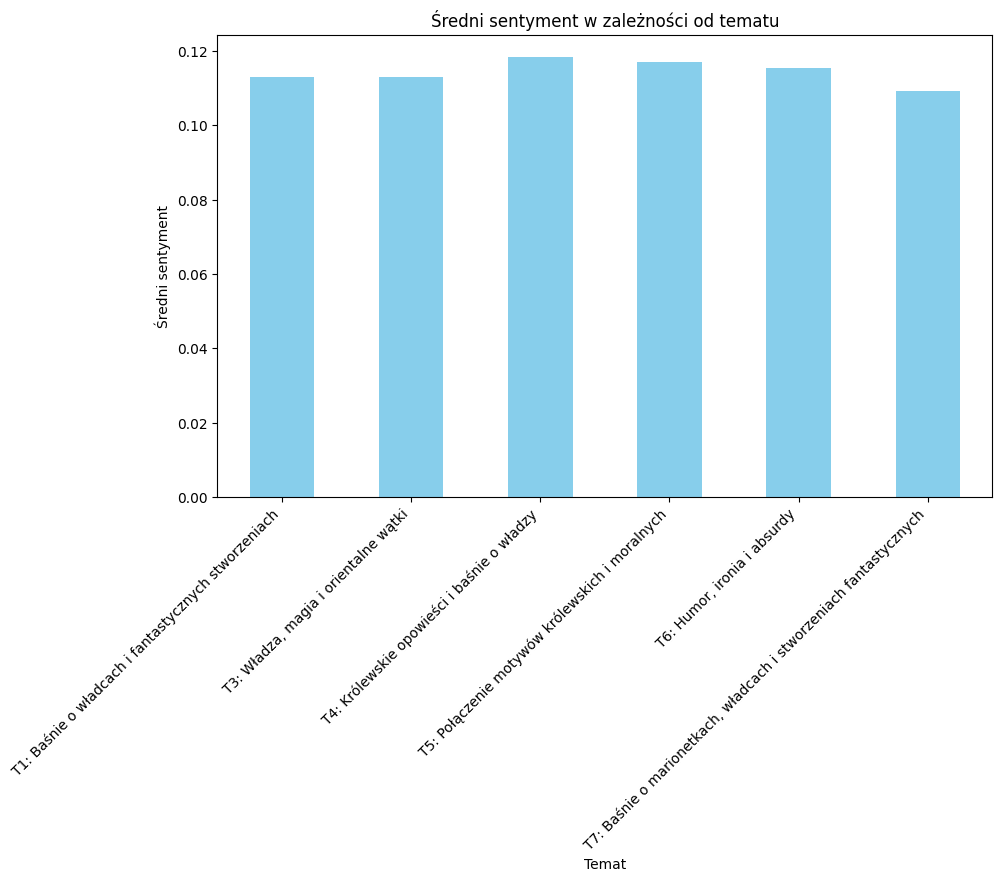

In [ ]:
sentiment_by_topic = CL_data_with_sentiments_df.groupby('Dominujący temat')['Polarity'].mean()

sentiment_by_topic.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Średni sentyment w zależności od tematu')
plt.xlabel('Temat')
plt.ylabel('Średni sentyment')
plt.xticks(rotation=45, ha='right')
plt.show()

### 6. Ewaluacja

**Cel:**  Sprawdzenie jakości predykcji i zdolności modelu

 Podział danych:
 - Zbiór treningowy: 80%.
 - Zbiór testowy: 20%.


 Metryki oceny:
 - Accuracy score
 - Precision, Recall, F1-score


In [ ]:
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
CL_data_with_sentiments_df = pd.DataFrame(CL_data_with_sentiments, columns=["content"])

In [ ]:
# Przygotowanie cech i etykiet
X_train = [story['content'] for story in CL_data]
y_train = [story['Sentyment'] for story in CL_data_with_sentiments]

In [ ]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

from sklearn.feature_extraction.text import CountVectorizer

print(f"Liczba próbek po wektoryzacji: {X_train_vectorized.shape[0]}")
print(f"Liczba etykiet: {len(y_train)}")

if X_train_vectorized.shape[0] == len(y_train):
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)
else:
    print("Liczby próbek w X_train i y_train są różne!")

Liczba próbek po wektoryzacji: 160
Liczba etykiet: 160


In [ ]:
# Przygotowanie cech i etykiet dla danych testowych
X_test = [story['content'] for story in test_CL_data]
y_test = [story['Sentyment'] for story in test_CL_data_with_sentiments]  # poprawione na iterację przez listę

In [ ]:
X_test_vectorized = vectorizer.transform(X_test)


print(f"Liczba próbek po wektoryzacji dla danych testowych: {X_test_vectorized.shape[0]}")
print(f"Liczba etykiet dla danych testowych: {len(y_test)}")

Liczba próbek po wektoryzacji dla danych testowych: 40
Liczba etykiet dla danych testowych: 40


Accuracy Score

In [ ]:
model = MultinomialNB()
model.fit(X_train_final, y_train_final)

y_pred = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy Score- dokładność: {accuracy}")
print("Raport klasyfikacji:\n", report)

Accuracy Score- dokładność: 0.875
Raport klasyfikacji:
               precision    recall  f1-score   support

   Neutralne       0.38      1.00      0.55         3
   Pozytywne       1.00      0.86      0.93        37

    accuracy                           0.88        40
   macro avg       0.69      0.93      0.74        40
weighted avg       0.95      0.88      0.90        40



### Analiza Raportu Klasyfikacji

1. **Klasy**:
   - **Neutralne**: 3 próbki
   - **Pozytywne**: 37 próbek

2. **Precision (Precyzja)**:
   - **Neutralne**: 0.38 - z wszystkich przypadków, które model sklasyfikował jako neutralne, tylko 38% było rzeczywiście neutralnych.
   - **Pozytywne**: 1.00 - Model poprawnie sklasyfikował wszystkie przypadki pozytywne.

3. **Recall (Czułość)**:
   - **Neutralne**: 1.00 - Model zdołał poprawnie zidentyfikować wszystkie próbki neutralne w zbiorze testowym.
   - **Pozytywne**: 0.86 - Model poprawnie sklasyfikował 86% wszystkich próbek pozytywnych.

4. **F1-Score**:
   - **Neutralne**: 0.55 - F1-score dla klasy neutralnej jest stosunkowo niski, co sugeruje, że model ma trudności z klasyfikowaniem tej klasy.
   - **Pozytywne**: 0.93 - F1-score dla klasy pozytywnej jest bardzo wysoki, co oznacza, że model dobrze radzi sobie z tą klasą.

5. **Podsumowanie**:
   - **Accuracy (Dokładność)**: 0.88 - Całkowita dokładność modelu wynosi 88%
   - **Macro Average**:
     - Precyzja: 0.69
     - Czułość: 0.93
     - F1-score: 0.74
   - **Weighted Average**:
     - Precyzja: 0.95
     - Czułość: 0.88
     - F1-score: 0.90

Model osiągnął solidną dokładność i dobre wyniki dla klasy pozytywnej.

In [ ]:
CL_data_with_sentiments_df = pd.DataFrame(CL_data_with_sentiments)
test_CL_data_with_sentiments_df = pd.DataFrame(test_CL_data_with_sentiments)

In [ ]:
def textblob_sentiment(text):
    analysis = TextBlob(text)
    return 'Pozytywne' if analysis.sentiment.polarity > 0.11 else 'Negatywne' if analysis.sentiment.polarity < -0.11 else 'Neutralne'

# Predykcja na zbiorze treningowym i testowym
y_pred_train = list(map(textblob_sentiment, X_train))
y_pred_test = list(map(textblob_sentiment, X_test))

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Dokładność na zbiorze treningowym (TextBlob): {train_accuracy:.2f}")
print(f"Dokładność na zbiorze testowym (TextBlob): {test_accuracy:.2f}")

Dokładność na zbiorze treningowym (TextBlob): 1.00
Dokładność na zbiorze testowym (TextBlob): 1.00


In [ ]:
for i in range(10):
    short_text = X_test[i][:30] + '...' if len(X_test[i]) > 30 else X_test[i]
    print(f"Treść: {short_text}, Przewidywanie: {y_pred_test[i]}, Rzeczywisty Sentyment: {y_test[i]}")

Treść: little tiny thumbelina woman w..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: nightingale china daresay know..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: sacred milk koumongoe far way ..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: drakestail drakestail little c..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: find true friend upon time liv..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: thumbelina woman wanted quite ..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: legend little weaver duleek ga..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: masonwork remembered resolutio..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: seventh story took place palac..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: Pozytywne
Treść: old church bell written schill..., Przewidywanie: Pozytywne, Rzeczywisty Sentyment: 

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_vectorized, y_train, cv=5)
print(f"Wyniki walidacji krzyżowej: {scores}")
print(f"Średnia dokładność walidacji krzyżowej: {scores.mean():.2f}")

Wyniki walidacji krzyżowej: [0.9375  0.90625 0.875   0.90625 0.90625]
Średnia dokładność walidacji krzyżowej: 0.91


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### VADER

In [ ]:
sid = SentimentIntensityAnalyzer()

def vader_sentiment(sent):
    ss = sid.polarity_scores(sent)
    return np.argmax(list(ss.values())[:-1])  # 0 = negative, 1 = neutral, 2 = positive

y_pred_train_vader = list(map(vader_sentiment, tqdm(X_train)))
y_pred_test_vader = list(map(vader_sentiment, tqdm(X_test)))

y_pred_train_vader = ['negative' if i == 0 else 'neutral' if i == 1 else 'positive' for i in y_pred_train_vader]
y_pred_test_vader = ['negative' if i == 0 else 'neutral' if i == 1 else 'positive' for i in y_pred_test_vader]

train_accuracy_vader = accuracy_score(y_train, y_pred_train_vader)
test_accuracy_vader = accuracy_score(y_test, y_pred_test_vader)

print(f"Dokładność na zbiorze treningowym (VADER): {train_accuracy_vader:.2f}")
print(f"Dokładność na zbiorze testowym (VADER): {test_accuracy_vader:.2f}")

  1%|          | 1/160 [55:01<145:48:06, 3301.17s/it]

In [ ]:
y_pred_series = pd.Series(y_pred_test_vader)
y_pred_series.value_counts().plot(kind='bar')
plt.title('Rozkład przewidywanych sentymentów (VADER)')
plt.xlabel('Sentyment')
plt.ylabel('Liczba')
plt.xticks(rotation=0)
plt.show()

Bag of Words (BoW) – Reprezentacja Binarna i Częstościowa

In [ ]:
# Reprezentacja binarna
count_vec_bin = CountVectorizer(binary=True)
X_train_bin = count_vec_bin.fit_transform(X_train)
X_test_bin = count_vec_bin.transform(X_test)

# Reprezentacja częstościowa
count_vec_freq = CountVectorizer(binary=False)
X_train_freq = count_vec_freq.fit_transform(X_train)
X_test_freq = count_vec_freq.transform(X_test)

# Wizualizacja
def bow_matrix_to_table(matrix, features):
    return pd.DataFrame(data=matrix.toarray(), columns=features)

# Reprezentacja binarna
print("Reprezentacja binarna:")
print(bow_matrix_to_table(X_train_bin, count_vec_bin.get_feature_names_out()).head())

# Reprezentacja częstościowa
print("Reprezentacja częstościowa:")
print(bow_matrix_to_table(X_train_freq, count_vec_freq.get_feature_names_out()).head())

Reprezentacja binarna:
   aa  aaam  aab  aabeen  aabeh  aabehs  aaf  aah  aahs  aaif  ...  zulyezen  \
0   1     1    1       1      1       1    1    1     1     1  ...         1   
1   1     1    1       1      1       1    1    1     1     1  ...         1   
2   1     1    1       1      1       1    1    1     1     1  ...         1   
3   1     0    0       0      0       0    0    0     0     0  ...         0   
4   0     0    0       0      0       0    0    0     0     0  ...         0   

   zum  zur  zurbajeh  zurzur  zuwaylah  zuweyleh  zuweylehthe  zuz  zylland  
0    1    1         1       1         1         1            1    1        1  
1    1    1         1       1         1         1            1    1        1  
2    1    1         1       1         1         1            1    1        1  
3    1    1         0       1         1         0            0    1        1  
4    0    0         0       0         0         0            0    0        0  

[5 rows x 34780 colum

In [ ]:
features = count_vec_bin.get_feature_names_out()
random_indices = np.random.choice(len(features), size=20, replace=False)
random_features = features[random_indices]
print("Losowe 20 cech:", random_features)

Losowe 20 cech: ['equitably' 'lathe' 'hammering' 'counterpanes' 'ninepenny' 'waterpail'
 'ods' 'banished' 'paperarello' 'wellsplashthey' 'alack' 'fattestin'
 'oysters' 'jura' 'stamp' 'entirelybut' 'beak' 'mistake' 'message'
 'doings']


N-gramy

In [ ]:
count_vec_ngram = CountVectorizer(ngram_range=(1, 3))
X_train_ngram = count_vec_ngram.fit_transform(X_train)
X_test_ngram = count_vec_ngram.transform(X_test)

print("Reprezentacja n-gramów (1-3):")
print(bow_matrix_to_table(X_train_ngram, count_vec_ngram.get_feature_names_out()).head())

Reprezentacja n-gramów (1-3):
   aa  aa beautiful  aa beautiful house  aa noise  aa noise ii  aa quail  \
0   3             1                   1         1            1         1   
1   3             1                   1         1            1         1   
2   2             1                   1         0            0         1   
3   1             1                   1         0            0         0   
4   0             0                   0         0            0         0   

   aa quail wild  aaam  aaam knowledge  aaam knowledge imparted  ...  \
0              1     1               1                        1  ...   
1              1     1               1                        1  ...   
2              1     1               1                        1  ...   
3              0     0               0                        0  ...   
4              0     0               0                        0  ...   

   zuweyleh properly zaweeleh  zuweylehthe  zuweylehthe walee  \
0              

TF-IDF

In [ ]:
tfidf = TfidfVectorizer(use_idf=True, norm='l2', smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Reprezentacja TF-IDF:")
print(bow_matrix_to_table(X_train_tfidf, tfidf.get_feature_names_out()).head())

Reprezentacja TF-IDF:
         aa      aaam       aab    aabeen     aabeh    aabehs       aaf  \
0  0.000120  0.000078  0.000156  0.000078  0.000156  0.000078  0.000156   
1  0.000122  0.000080  0.000159  0.000080  0.000159  0.000080  0.000159   
2  0.000084  0.000082  0.000165  0.000082  0.000165  0.000082  0.000165   
3  0.000048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        aah      aahs      aaif  ...  zulyezen       zum       zur  zurbajeh  \
0  0.001250  0.000078  0.000469  ...  0.000078  0.000528  0.000047  0.000078   
1  0.001274  0.000080  0.000478  ...  0.000080  0.000538  0.000048  0.000080   
2  0.001317  0.000082  0.000494  ...  0.000082  0.000556  0.000049  0.000082   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000638  0.000057  0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

     zurzur  zuwaylah  zuweyleh  zuweylehthe  

Trenowanie modelu Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Trening modelu Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

y_train_pred = clf.predict(X_train_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

multiNB_train_score = accuracy_score(y_train, y_train_pred)
multiNB_test_score = accuracy_score(y_test, y_test_pred)

print(f"Naive Bayes - Dokładność na zbiorze treningowym: {multiNB_train_score}")
print(f"Naive Bayes - Dokładność na zbiorze testowym: {multiNB_test_score}")

print(classification_report(y_test, y_test_pred, zero_division=0))
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

Naive Bayes - Dokładność na zbiorze treningowym: 0.8875
Naive Bayes - Dokładność na zbiorze testowym: 0.925
              precision    recall  f1-score   support

   Neutralne       0.00      0.00      0.00         3
   Pozytywne       0.93      1.00      0.96        37

    accuracy                           0.93        40
   macro avg       0.46      0.50      0.48        40
weighted avg       0.86      0.93      0.89        40

[[ 0  3]
 [ 0 37]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Trening modelu SVM z automatycznym ważeniem klas
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność modelu SVM: {accuracy:.2f}")

Dokładność modelu SVM: 0.88


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
svm_model.fit(X_resampled, y_resampled)
y_pred = svm_model.predict(X_test_tfidf)

In [ ]:
unique_classes, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))
print("Rozkład klas w zbiorze treningowym:", class_distribution)

Rozkład klas w zbiorze treningowym: {'Neutralne': 18, 'Pozytywne': 142}


In [ ]:
# Generowanie raportu klasyfikacji z uwzględnieniem wszystkich klas
print(classification_report(y_test, y_pred, target_names=['Pozytywne', 'Neutralne', 'Negatywne'], labels=[0, 1, 2], zero_division=0))

              precision    recall  f1-score   support

   Pozytywne       0.00      0.00      0.00         0
   Neutralne       0.00      0.00      0.00         0
   Negatywne       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



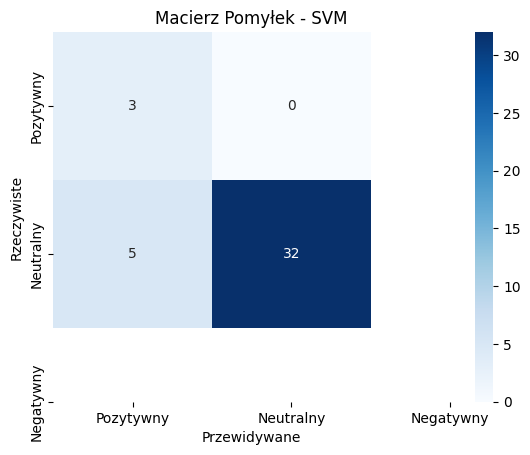

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pozytywny', 'Neutralny', 'Negatywny'], yticklabels=['Pozytywny', 'Neutralny', 'Negatywny'])
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Pomyłek - SVM')
plt.show()